<a href="https://colab.research.google.com/github/cconsta1/DentalAgeClassification-scripts/blob/main/DentalAgeClassification_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -----------------------------
# Data Loading and Setup
# -----------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import re
from scipy import stats
import json
from datetime import datetime
import zipfile

warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device.")


import zipfile
import shutil

zip_path = '/content/drive/MyDrive/DentAgePooledDatav2.zip'
local_zip = './DentAgePooledDatav2.zip'
local_extract = '.'


if not os.path.exists(local_zip):
    print("Copying ZIP from Drive to Colab local disk (safe copy)...")
    with open(zip_path, 'rb') as src, open(local_zip, 'wb') as dst:
        shutil.copyfileobj(src, dst, length=1024*1024)  # 1 MB buffer
    print("Copy complete.")
else:
    print("Local ZIP already exists.")

print(f"Drive ZIP size: {os.path.getsize(zip_path)}")
print(f"Local ZIP size: {os.path.getsize(local_zip)}")

if not os.path.exists('./DentAgePooledDatav2'):
    print("Extracting ZIP...")
    try:
        with zipfile.ZipFile(local_zip, 'r') as zip_ref:
            zip_ref.extractall(local_extract)
        print("Extraction complete.")
    except zipfile.BadZipFile:
        raise RuntimeError("ERROR: The copied ZIP is corrupted. Delete it and rerun the copy step.")
else:
    print("Dataset already extracted.")

DATASET_PATH = './DentAgePooledDatav2'
print(f"Dataset path: {DATASET_PATH}")


Using cuda device.
Copying ZIP from Drive to Colab local disk (safe copy)...
Copy complete.
Drive ZIP size: 2615318924
Local ZIP size: 2615318924
Extracting ZIP...
Extraction complete.
Dataset path: ./DentAgePooledDatav2


Creating dataset DataFrame (ages 14-24 years)...
Found 2623 total image files
After removing duplicates: 2623 files
Files with valid age (14-24) and gender: 1764

Age distribution:
Age 14: 250 samples
Age 15: 179 samples
Age 16: 188 samples
Age 17: 174 samples
Age 18: 167 samples
Age 19: 167 samples
Age 20: 161 samples
Age 21: 152 samples
Age 22: 127 samples
Age 23: 126 samples
Age 24: 73 samples

Gender distribution:
F: 914 samples
M: 850 samples

Dataset Summary:
Total samples: 1764
DataFrame shape: (1764, 5)
Columns: ['filepath', 'filename', 'age', 'gender', 'file_extension']
Age range: 14 - 24 years


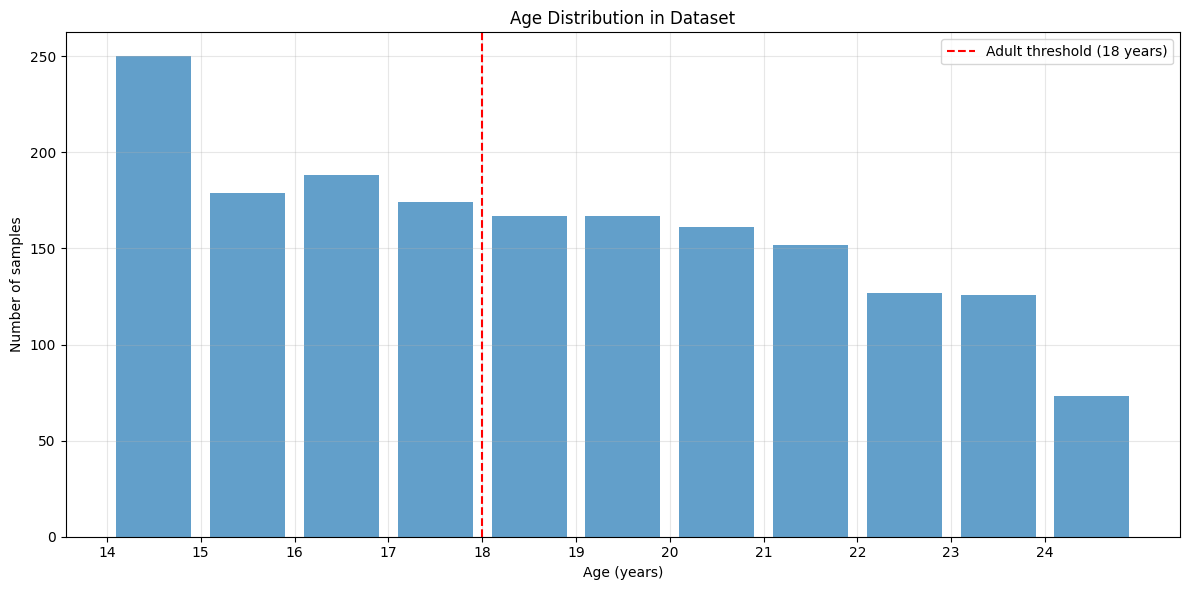

In [2]:
# Metadata extraction and DataFrame creation
def extract_metadata_from_filename(filepath):
    """Extract age, gender from filename and folder"""
    filename = os.path.basename(filepath)
    folder_name = os.path.basename(os.path.dirname(filepath))

    # Extract age from folder name (e.g., "14Y" -> 14)
    age_match = re.search(r'(\d+)Y', folder_name)
    age = int(age_match.group(1)) if age_match else None

    # Extract gender - Look for M or F in filename (case insensitive)
    gender = None
    filename_upper = filename.upper()
    if 'F' in filename_upper:
        gender = 'F'
    elif 'M' in filename_upper:
        gender = 'M'

    return {
        'filepath': filepath,
        'filename': filename,
        'age': age,
        'gender': gender,
        'file_extension': os.path.splitext(filename)[1]
    }

def create_dataset_dataframe(dataset_path):
    """Create DataFrame with ages 14-24 only"""
    data_list = []

    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.bmp', '*.png',
                       '*.JPG', '*.JPEG', '*.BMP', '*.PNG']
    all_files = []

    for ext in image_extensions:
        all_files.extend(glob.glob(os.path.join(dataset_path, '**', ext), recursive=True))

    print(f"Found {len(all_files)} total image files")

    # Remove duplicates
    all_files = list(set(all_files))
    print(f"After removing duplicates: {len(all_files)} files")

    for filepath in all_files:
        metadata = extract_metadata_from_filename(filepath)

        # Only process files in age range 14-24 with valid gender
        if (metadata['age'] is not None and 14 <= metadata['age'] <= 24
            and metadata['gender'] is not None):
            data_list.append(metadata)

    print(f"Files with valid age (14-24) and gender: {len(data_list)}")

    df = pd.DataFrame(data_list)

    if len(df) > 0:
        # Age distribution
        age_counts = df['age'].value_counts().sort_index()
        print(f"\nAge distribution:")
        for age in sorted(age_counts.index):
            print(f"Age {age}: {age_counts[age]} samples")

        # Gender distribution
        gender_counts = df['gender'].value_counts()
        print(f"\nGender distribution:")
        for gender, count in gender_counts.items():
            print(f"{gender}: {count} samples")

    return df

# Create the dataset DataFrame
print("Creating dataset DataFrame (ages 14-24 years)...")
df_fixed = create_dataset_dataframe(DATASET_PATH)

print(f"\nDataset Summary:")
print(f"Total samples: {len(df_fixed)}")
print(f"DataFrame shape: {df_fixed.shape}")
print(f"Columns: {list(df_fixed.columns)}")

if len(df_fixed) > 0:
    print(f"Age range: {df_fixed['age'].min()} - {df_fixed['age'].max()} years")

    # Add binary label (minor/adult) and normalized age
    age_min, age_max = df_fixed['age'].min(), df_fixed['age'].max()
    df_fixed['bin_label'] = (df_fixed['age'] >= 18).astype(int)
    df_fixed['age_norm'] = (df_fixed['age'] - age_min) / (age_max - age_min)

    # Histogram of age distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_fixed['age'], bins=range(14, 26), alpha=0.7, rwidth=0.8)
    plt.axvline(x=18, color='red', linestyle='--', label='Adult threshold (18 years)')
    plt.xlabel('Age (years)')
    plt.ylabel('Number of samples')
    plt.title('Age Distribution in Dataset')
    plt.xticks(range(14, 25))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No valid samples found!")

In [3]:
# Data Augmentation Visualization
def visualize_transformations(image_path):
    """Visualize various transformations applied to a dental panoramic image"""
    original = Image.open(image_path).convert('RGB')

    # Define transformations
    transform_list = {
        'Original': transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
        ]),
        'Normalized': transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'Horizontal Flip': transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
        ]),
        'Rotation': transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.RandomRotation(degrees=10),
            transforms.ToTensor(),
        ]),
        'Color Jitter': transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ColorJitter(brightness=0.15, contrast=0.15),
            transforms.ToTensor(),
        ]),
        'Random Erasing': transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.RandomErasing(p=1.0, scale=(0.02, 0.1))
        ])
    }

    # Apply transformations and visualize
    plt.figure(figsize=(15, 8))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(original)
    plt.title('Original Image')
    plt.axis('off')

    # Transformed images
    for i, (name, transform) in enumerate(list(transform_list.items())[1:], start=2):
        img_tensor = transform(original)

        # For display
        if 'Normalized' in name:
            # Denormalize for display
            img_np = img_tensor.numpy().transpose(1, 2, 0)
            img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_np = np.clip(img_np, 0, 1)
        else:
            img_np = img_tensor.numpy().transpose(1, 2, 0)

        plt.subplot(2, 3, i)
        plt.imshow(img_np)
        plt.title(name)
        plt.axis('off')

    plt.suptitle('Dental X-ray Image Preprocessing Pipeline', fontsize=16)
    plt.tight_layout()
    plt.savefig('transformation_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

    return "Image transformation pipeline visualized"



In [ ]:
# Sample one image from each age group
sample_image = df_fixed.iloc[48]['filepath']
visualize_transformations(sample_image)

In [4]:
# Fixed get_transforms function for backbone compatibility
def get_transforms(augment=False, backbone='efficientnet'):
    """Get training and validation transforms with optional augmentation"""
    # ViT requires 224x224 input, EfficientNet can work with 384x384
    img_size = 224 if backbone == 'vit' else 384

    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5) if augment else transforms.Lambda(lambda x: x),
        transforms.RandomRotation(degrees=10) if augment else transforms.Lambda(lambda x: x),
        transforms.ColorJitter(brightness=0.15, contrast=0.15) if augment else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)) if augment else transforms.Lambda(lambda x: x)
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

# Age to class mapping
age_min, age_max = 14, 24
age2class = {age: idx for idx, age in enumerate(range(age_min, age_max+1))}
class2age = {v: k for k, v in age2class.items()}
n_classes = len(age2class)

def normalize_age(age):
    """Normalize age to [0, 1] range"""
    return (age - age_min) / (age_max - age_min)

def denormalize_age(norm_age):
    """Denormalize age from [0, 1] range"""
    return norm_age * (age_max - age_min) + age_min

In [12]:
# Flexible Dataset class for all task types
class DentalAgeDataset(Dataset):
    def __init__(self, dataframe, transform, task_type='binary'):
        """
        task_type: 'binary' (adult/minor), 'multiclass' (per-year), or 'regression'
        """
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.task_type = task_type

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filepath']).convert('L')  # Convert to grayscale
        img = img.convert('RGB')  # Convert back to RGB for model compatibility
        img = self.transform(img)

        if self.task_type == 'binary':
            # Binary classification: 0 for minor, 1 for adult
            label = 1 if int(row['age']) >= 18 else 0
        elif self.task_type == 'multiclass':
            # Multiclass classification: map age to class index
            label = age2class[int(row['age'])]
        elif self.task_type == 'regression':
            # Regression: normalize age to [0, 1]
            label = np.float32(row['age_norm'])
        else:
            raise ValueError(f"Unknown task type: {self.task_type}")

        return img, label

In [8]:
# Flexible Neural Network Architecture
class DentalAgeModel(nn.Module):
    def __init__(self, task_type='binary', backbone='efficientnet', use_attention=True):
        """
        Initialize a model for dental age estimation.

        Args:
            task_type: 'binary' (adult/minor), 'multiclass' (per-year), or 'regression'
            backbone: 'efficientnet' or 'vit'
            use_attention: Whether to use self-attention mechanism
        """
        super().__init__()
        self.task_type = task_type
        self.backbone_type = backbone
        self.use_attention = use_attention

        # Feature extractor
        if backbone == 'efficientnet':
            self.backbone = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
            self.backbone.classifier = nn.Identity()
            self.feature_dim = 1280
        elif backbone == 'vit':
            self.backbone = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
            self.backbone.heads = nn.Identity()
            self.feature_dim = 768
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # Self-attention mechanism
        if use_attention:
            self.attention = SelfAttention(self.feature_dim)

        # Task-specific layers
        if task_type in ['binary', 'regression']:
            # Binary classification or regression
            self.fc1 = nn.Linear(self.feature_dim, 256)
            self.bn1 = nn.BatchNorm1d(256)
            self.dropout1 = nn.Dropout(0.2)
            self.fc2 = nn.Linear(256, 128)
            self.bn2 = nn.BatchNorm1d(128)
            self.dropout2 = nn.Dropout(0.2)
            self.fc3 = nn.Linear(128, 1)
        elif task_type == 'multiclass':
            # Multiclass classification
            self.fc1 = nn.Linear(self.feature_dim, 512)
            self.bn1 = nn.BatchNorm1d(512)
            self.dropout1 = nn.Dropout(0.25)
            self.fc2 = nn.Linear(512, 256)
            self.bn2 = nn.BatchNorm1d(256)
            self.dropout2 = nn.Dropout(0.25)
            self.fc3 = nn.Linear(256, 128)
            self.bn3 = nn.BatchNorm1d(128)
            self.dropout3 = nn.Dropout(0.25)
            self.fc4 = nn.Linear(128, n_classes)

    def forward(self, x):
        # Extract features
        features = self.backbone(x)

        # Apply attention if specified
        if self.use_attention:
            features = self.attention(features)

        # Task-specific forward pass
        if self.task_type == 'multiclass':
            x = self.fc1(features)
            x = self.bn1(x)
            x = F.relu(x)
            x = self.dropout1(x)

            x = self.fc2(x)
            x = self.bn2(x)
            x = F.relu(x)
            x = self.dropout2(x)

            x = self.fc3(x)
            x = self.bn3(x)
            x = F.relu(x)
            x = self.dropout3(x)

            x = self.fc4(x)
            return x  # No activation for multiclass (will use with CrossEntropyLoss)
        else:
            # For binary and regression
            x = self.fc1(features)
            x = self.bn1(x)
            x = F.relu(x)
            x = self.dropout1(x)

            x = self.fc2(x)
            x = self.bn2(x)
            x = F.relu(x)
            x = self.dropout2(x)

            x = self.fc3(x).squeeze(1)

            # Apply sigmoid for binary classification and regression
            if self.task_type in ['binary', 'regression']:
                x = torch.sigmoid(x)

            return x

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        q = self.query(x).unsqueeze(1)  # (batch, 1, hidden_dim)
        k = self.key(x).unsqueeze(1)    # (batch, 1, hidden_dim)
        v = self.value(x).unsqueeze(1)  # (batch, 1, hidden_dim)
        attn_weights = self.softmax(torch.bmm(q, k.transpose(1,2)) / (x.size(1) ** 0.5))
        attn_output = torch.bmm(attn_weights, v)
        return attn_output.squeeze(1)

In [10]:
# Fix prepare_data function to handle different backbones
def prepare_data(df, task_type='binary', augment=False, sex_filter=None, backbone='efficientnet'):
    """
    Prepare data for model training.

    Args:
        df: DataFrame with dataset
        task_type: 'binary', 'multiclass', or 'regression'
        augment: Whether to apply data augmentation
        sex_filter: None for all, 'M' for males only, 'F' for females only
        backbone: 'efficientnet' or 'vit'

    Returns:
        train_loader, val_loader, train_df, val_df
    """
    # Filter by sex if needed
    if sex_filter in ['M', 'F']:
        df = df[df['gender'] == sex_filter].reset_index(drop=True)
        print(f"Using {sex_filter} only data: {len(df)} samples")

    # Get transforms with appropriate size for backbone
    train_transform, val_transform = get_transforms(augment, backbone)

    # Prepare for stratification
    if task_type == 'binary':
        stratify_col = 'bin_label'
    else:
        # For multiclass and regression, stratify by age
        stratify_col = 'age'

    # Split data
    train_df, val_df = train_test_split(
        df, test_size=0.2,
        stratify=df[stratify_col],
        random_state=42
    )

    # Create datasets
    train_dataset = DentalAgeDataset(train_df, train_transform, task_type)
    val_dataset = DentalAgeDataset(val_df, val_transform, task_type)

    # Create data loaders
    batch_size = 32 if task_type == 'regression' else 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

    # Data augmentation (if needed) - duplicate training data with transforms
    if augment:
        # Create augmented version of training data
        train_aug_dataset = DentalAgeDataset(train_df, train_transform, task_type)
        train_combined = torch.utils.data.ConcatDataset([train_dataset, train_aug_dataset])
        train_loader = DataLoader(train_combined, batch_size=batch_size, shuffle=True, num_workers=2)
        print(f"Augmented train samples: {len(train_combined)}")

    return train_loader, val_loader, train_df, val_df

In [ ]:
# Universal training function
def train_model(model, train_loader, val_loader, task_type='binary', num_epochs=25):
    """
    Train a model for any of the task types.

    Args:
        model: The model to train
        train_loader, val_loader: Data loaders
        task_type: 'binary', 'multiclass', or 'regression'
        num_epochs: Number of epochs to train

    Returns:
        Trained model, loss history, performance history
    """
    # Set up loss function and optimizer
    if task_type == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif task_type == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif task_type == 'regression':
        criterion = nn.MSELoss()
    else:
        raise ValueError(f"Unknown task type: {task_type}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5
    )

    # Training history
    train_losses, val_losses = [], []
    performance_history = []
    best_metric = float('inf') if task_type == 'regression' else 0
    patience, patience_counter = 7, 0

    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)

            if task_type == 'binary':
                # Binary classification needs logits, but our model outputs sigmoids
                loss = criterion(outputs, labels.float())
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)

                if task_type == 'binary':
                    loss = criterion(outputs, labels.float())
                    preds = (outputs >= 0.5).float()
                elif task_type == 'multiclass':
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)
                else:  # regression
                    loss = criterion(outputs, labels)
                    preds = outputs

                val_loss += loss.item()
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate performance metrics
        if task_type == 'binary':
            acc = accuracy_score(val_targets, val_preds)
            performance_metric = acc
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {acc:.4f}")
        elif task_type == 'multiclass':
            acc = accuracy_score(val_targets, val_preds)
            performance_metric = acc
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {acc:.4f}")
        else:  # regression
            # Convert predictions back to years
            val_pred_years = [denormalize_age(x) for x in val_preds]
            val_true_years = [denormalize_age(x) for x in val_targets]
            mae = mean_absolute_error(val_true_years, val_pred_years)
            performance_metric = mae  # Lower is better for MAE
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val MAE: {mae:.3f}")

        performance_history.append(performance_metric)

        # Early stopping and model saving
        improved = False
        if task_type == 'regression':
            # For regression, lower MAE is better
            if performance_metric < best_metric:
                best_metric = performance_metric
                improved = True
        else:
            # For classification, higher accuracy is better
            if performance_metric > best_metric:
                best_metric = performance_metric
                improved = True

        if improved:
            patience_counter = 0
            print(f"New best model with {'MAE' if task_type == 'regression' else 'accuracy'}: {best_metric:.4f}")

            # Save the model
            MODEL_DIR = f"/content/drive/MyDrive/models/DentalAge_{task_type}_{model.backbone_type}"
            os.makedirs(MODEL_DIR, exist_ok=True)
            torch.save(model.state_dict(), f"{MODEL_DIR}/best_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        # Update learning rate
        scheduler.step(avg_val_loss)

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    metric_name = 'MAE (years)' if task_type == 'regression' else 'Accuracy'
    plt.plot(performance_history, color='green')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.title(f'Validation {metric_name}')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"{MODEL_DIR}/training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Load best model for evaluation
    model.load_state_dict(torch.load(f"{MODEL_DIR}/best_model.pth"))

    return model, train_losses, val_losses, performance_history

In [25]:
# Fixed Comprehensive evaluation function
def evaluate_model(model, val_loader, task_type='binary'):
    """
    Evaluate a model with comprehensive metrics.

    Args:
        model: The model to evaluate
        val_loader: Validation data loader
        task_type: 'binary', 'multiclass', or 'regression'

    Returns:
        Dictionary of performance metrics
    """
    model.eval()
    all_preds, all_targets = [], []
    all_outputs = []  # Store raw outputs for ROC calculation

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            # Store raw outputs for later use
            all_outputs.extend(outputs.cpu().numpy())

            if task_type == 'binary':
                preds = (outputs >= 0.5).float()
            elif task_type == 'multiclass':
                preds = torch.argmax(outputs, dim=1)
            else:  # regression
                preds = outputs

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_outputs = np.array(all_outputs)

    # Task-specific evaluation
    if task_type == 'binary':
        # Binary classification metrics
        acc = accuracy_score(all_targets, all_preds)
        precision = precision_score(all_targets, all_preds)
        recall = sensitivity = recall_score(all_targets, all_preds)
        specificity = recall_score(1-all_targets, 1-all_preds)
        f1 = f1_score(all_targets, all_preds)

        # Calculate confidence intervals (95%) using bootstrapping
        n_bootstraps = 1000
        rng = np.random.RandomState(42)

        bootstrap_acc = []
        bootstrap_sensitivity = []
        bootstrap_specificity = []

        for _ in range(n_bootstraps):
            indices = rng.randint(0, len(all_preds), len(all_preds))
            if len(np.unique(all_targets[indices])) < 2:
                continue  # Skip if only one class is present

            boot_acc = accuracy_score(all_targets[indices], all_preds[indices])
            boot_sens = recall_score(all_targets[indices], all_preds[indices], zero_division=0)
            boot_spec = recall_score(1-all_targets[indices], 1-all_preds[indices], zero_division=0)

            bootstrap_acc.append(boot_acc)
            bootstrap_sensitivity.append(boot_sens)
            bootstrap_specificity.append(boot_spec)

        # Calculate confidence intervals
        alpha = 0.95
        ci_acc = np.percentile(bootstrap_acc, [(1-alpha)/2 * 100, (alpha + (1-alpha)/2) * 100])
        ci_sens = np.percentile(bootstrap_sensitivity, [(1-alpha)/2 * 100, (alpha + (1-alpha)/2) * 100])
        ci_spec = np.percentile(bootstrap_specificity, [(1-alpha)/2 * 100, (alpha + (1-alpha)/2) * 100])

        # Confusion matrix
        cm = confusion_matrix(all_targets, all_preds)
        tn, fp, fn, tp = cm.ravel()

        # ROC curve and AUC - using all_outputs instead of outputs
        roc_auc = roc_auc_score(all_targets, all_outputs)

        metrics = {
            'accuracy': acc,
            'accuracy_ci': ci_acc,
            'sensitivity': sensitivity,
            'sensitivity_ci': ci_sens,
            'specificity': specificity,
            'specificity_ci': ci_spec,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm,
            'predictions': all_preds,
            'targets': all_targets,
            'probabilities': all_outputs
        }

        print("\nBinary Classification Results:")
        print(f"Accuracy: {acc:.4f} (95% CI: {ci_acc[0]:.4f}-{ci_acc[1]:.4f})")
        print(f"Sensitivity (TPR): {sensitivity:.4f} (95% CI: {ci_sens[0]:.4f}-{ci_sens[1]:.4f})")
        print(f"Specificity (TNR): {specificity:.4f} (95% CI: {ci_spec[0]:.4f}-{ci_spec[1]:.4f})")
        print(f"Precision (PPV): {precision:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print("\nConfusion Matrix:")
        print(f"TN: {tn}, FP: {fp}")
        print(f"FN: {fn}, TP: {tp}")

    elif task_type == 'multiclass':
        # Convert class indices to ages
        all_pred_ages = np.array([class2age[x] for x in all_preds])
        all_true_ages = np.array([class2age[x] for x in all_targets])

        # Classification metrics
        acc = accuracy_score(all_targets, all_preds)
        mae = mean_absolute_error(all_true_ages, all_pred_ages)
        rmse = np.sqrt(mean_squared_error(all_true_ages, all_pred_ages))

        # One-vs-rest classification metrics for each age class
        class_report = classification_report(all_targets, all_preds,
                                           target_names=[str(class2age[i]) for i in range(n_classes)],
                                           output_dict=True)

        # Confusion matrix
        cm = confusion_matrix(all_targets, all_preds)

        metrics = {
            'accuracy': acc,
            'mae': mae,
            'rmse': rmse,
            'class_report': class_report,
            'confusion_matrix': cm,
            'predictions': all_preds,
            'targets': all_targets
        }

        print("\nMulticlass Classification Results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"MAE (years): {mae:.3f}")
        print(f"RMSE (years): {rmse:.3f}")

    else:  # regression
        # Convert normalized predictions back to years
        all_pred_years = np.array([denormalize_age(x) for x in all_preds])
        all_true_years = np.array([denormalize_age(x) for x in all_targets])

        # Regression metrics
        mae = mean_absolute_error(all_true_years, all_pred_years)
        rmse = np.sqrt(mean_squared_error(all_true_years, all_pred_years))
        r2 = r2_score(all_true_years, all_pred_years)

        # Per-age MAE
        age_metrics = {}
        for age in range(age_min, age_max + 1):
            age_indices = [i for i, y in enumerate(all_true_years) if int(y) == age]
            if age_indices:
                age_true = all_true_years[age_indices]
                age_pred = all_pred_years[age_indices]
                age_mae = mean_absolute_error(age_true, age_pred)
                within_1yr = np.mean(np.abs(age_pred - age_true) <= 1.0)
                age_metrics[age] = {
                    'mae': age_mae,
                    'within_1yr': within_1yr,
                    'samples': len(age_indices)
                }

        # Calculate binary adult/minor classification metrics using regression predictions
        binary_preds = (all_pred_years >= 18).astype(int)
        binary_targets = (all_true_years >= 18).astype(int)
        binary_acc = accuracy_score(binary_targets, binary_preds)
        sensitivity = recall_score(binary_targets, binary_preds)
        specificity = recall_score(1-binary_targets, 1-binary_preds)

        # Confidence intervals for regression metrics using bootstrapping
        n_bootstraps = 1000
        rng = np.random.RandomState(42)
        bootstrap_mae = []
        bootstrap_binary_acc = []

        for _ in range(n_bootstraps):
            indices = rng.randint(0, len(all_pred_years), len(all_pred_years))
            boot_mae = mean_absolute_error(all_true_years[indices], all_pred_years[indices])
            boot_acc = accuracy_score(binary_targets[indices], binary_preds[indices])
            bootstrap_mae.append(boot_mae)
            bootstrap_binary_acc.append(boot_acc)

        # Calculate confidence intervals
        alpha = 0.95
        ci_mae = np.percentile(bootstrap_mae, [(1-alpha)/2 * 100, (alpha + (1-alpha)/2) * 100])
        ci_binary_acc = np.percentile(bootstrap_binary_acc, [(1-alpha)/2 * 100, (alpha + (1-alpha)/2) * 100])

        metrics = {
            'mae': mae,
            'mae_ci': ci_mae,
            'rmse': rmse,
            'r2': r2,
            'binary_acc': binary_acc,
            'binary_acc_ci': ci_binary_acc,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'age_metrics': age_metrics,
            'predictions': all_pred_years,
            'targets': all_true_years
        }

        print("\nRegression Results:")
        print(f"MAE (years): {mae:.3f} (95% CI: {ci_mae[0]:.3f}-{ci_mae[1]:.3f})")
        print(f"RMSE (years): {rmse:.3f}")
        print(f"R²: {r2:.3f}")
        print(f"Binary classification accuracy: {binary_acc:.4f} (95% CI: {ci_binary_acc[0]:.4f}-{ci_binary_acc[1]:.4f})")
        print(f"Sensitivity: {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")

        print("\nAge-specific MAE:")
        # for age, metrics in sorted(age_metrics.items()):
        #     print(f"Age {age}: {metrics['mae']:.3f} years, Within ±1 year: {metrics['within_1yr']:.1%} ({metrics['samples']} samples)")
        for age, m in sorted(age_metrics.items()):
          print(f"Age {age}: {m['mae']:.3f} years, Within ±1 year: {m['within_1yr']:.1%} ({m['samples']} samples)")


    return metrics

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

# Visualization functions for evaluation results
def visualize_binary_results(metrics):
    """Visualize binary classification results with clinical metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # ROC curve
    fpr, tpr, thresholds = roc_curve(metrics['targets'], metrics['probabilities'])
    roc_auc = metrics['roc_auc']

    ax1.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Confusion matrix
    cm = metrics['confusion_matrix']
    ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Confusion Matrix')
    tick_marks = np.arange(2)
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(['Minor (<18)', 'Adult (≥18)'])
    ax2.set_yticklabels(['Minor (<18)', 'Adult (≥18)'])
    ax2.set_ylabel('True Label')
    ax2.set_xlabel('Predicted Label')

    # Add text annotations to confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax2.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.savefig("binary_evaluation_results.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Bar chart for sensitivity and specificity with confidence intervals
    plt.figure(figsize=(10, 6))
    metrics_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score']
    metrics_values = [
        metrics['accuracy'],
        metrics['sensitivity'],
        metrics['specificity'],
        metrics['precision'],
        metrics['f1']
    ]

    # Add confidence intervals for metrics that have them
    yerr = np.zeros((2, 5))
    yerr[0, 0] = metrics['accuracy'] - metrics['accuracy_ci'][0]  # lower error for accuracy
    yerr[1, 0] = metrics['accuracy_ci'][1] - metrics['accuracy']  # upper error for accuracy
    yerr[0, 1] = metrics['sensitivity'] - metrics['sensitivity_ci'][0]  # lower error for sensitivity
    yerr[1, 1] = metrics['sensitivity_ci'][1] - metrics['sensitivity']  # upper error for sensitivity
    yerr[0, 2] = metrics['specificity'] - metrics['specificity_ci'][0]  # lower error for specificity
    yerr[1, 2] = metrics['specificity_ci'][1] - metrics['specificity']  # upper error for specificity

    bars = plt.bar(metrics_names, metrics_values, yerr=yerr, capsize=10, alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom')

    plt.ylim(0, 1.15)  # Set y-axis limit with space for error bars
    plt.title('Binary Classification Metrics with 95% Confidence Intervals')
    plt.ylabel('Score')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("binary_metrics_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def visualize_multiclass_results(metrics):
    """Visualize multiclass classification results"""
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = metrics['confusion_matrix']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, [str(class2age[i]) for i in range(n_classes)], rotation=45)
    plt.yticks(tick_marks, [str(class2age[i]) for i in range(n_classes)])
    plt.xlabel('Predicted Age')
    plt.ylabel('True Age')

    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=9)

    plt.tight_layout()
    plt.savefig("multiclass_confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot per-class metrics
    class_report = metrics['class_report']
    ages = [class2age[i] for i in range(n_classes)]
    precisions = [class_report[str(age)]['precision'] for age in ages]
    recalls = [class_report[str(age)]['recall'] for age in ages]
    f1_scores = [class_report[str(age)]['f1-score'] for age in ages]
    supports = [class_report[str(age)]['support'] for age in ages]

    plt.figure(figsize=(12, 6))
    x = np.arange(len(ages))
    width = 0.25

    plt.bar(x - width, precisions, width, label='Precision', alpha=0.7)
    plt.bar(x, recalls, width, label='Recall', alpha=0.7)
    plt.bar(x + width, f1_scores, width, label='F1 Score', alpha=0.7)

    plt.axvline(x=4-0.5, color='red', linestyle='--', alpha=0.5, label='Adult threshold (18 years)')

    plt.xlabel('Age')
    plt.ylabel('Score')
    plt.title('Performance Metrics by Age Class')
    plt.xticks(x, ages)
    plt.legend(loc='upper left')
    plt.grid(axis='y', alpha=0.3)

    # Add sample size annotations
    for i, support in enumerate(supports):
        plt.text(i, 0.05, f'n={support}', ha='center', rotation=90, alpha=0.7)

    plt.tight_layout()
    plt.savefig("multiclass_metrics_by_age.png", dpi=300, bbox_inches='tight')
    plt.show()

def visualize_regression_results(metrics):
    """Visualize regression results"""
    # predictions = metrics['predictions']
    # targets = metrics['targets']
    predictions = np.array(metrics.get('predictions', []))
    targets = np.array(metrics.get('targets', []))

    if len(predictions) == 0 or len(targets) == 0:
      print("Regression metrics missing predictions. Skipping regression plots.")
      return

    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Scatter plot: Predicted vs. True
    ax1.scatter(targets, predictions, alpha=0.6, label="Predictions")
    ax1.plot([age_min, age_max], [age_min, age_max], 'r--', label="Ideal")
    ax1.set_xlabel("True Age")
    ax1.set_ylabel("Predicted Age")
    ax1.set_title("Predicted vs. True Age")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(age_min - 0.5, age_max + 0.5)
    ax1.set_ylim(age_min - 0.5, age_max + 0.5)

    # Residuals plot
    residuals = predictions - targets
    ax2.scatter(targets, residuals, alpha=0.6)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel("True Age")
    ax2.set_ylabel("Residuals (Predicted - True)")
    ax2.set_title("Residuals")
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(age_min - 0.5, age_max + 0.5)

    # Age-specific performance
    ages = list(sorted(metrics['age_metrics'].keys()))
    mae_values = [metrics['age_metrics'][age]['mae'] for age in ages]
    within_1yr = [metrics['age_metrics'][age]['within_1yr'] * 100 for age in ages]
    sample_sizes = [metrics['age_metrics'][age]['samples'] for age in ages]

    ax3.bar(ages, within_1yr, alpha=0.7)
    ax3.set_xlabel("Age (years)")
    ax3.set_ylabel("% within ±1 year")
    ax3.set_title("Age-specific Performance")
    ax3.axvline(x=18, color='red', linestyle='--', alpha=0.7, label='Adult threshold')
    ax3.legend()
    ax3.set_ylim(0, 100)
    ax3.grid(axis='y', alpha=0.3)

    # Add sample size annotations
    for i, (age, count) in enumerate(zip(ages, sample_sizes)):
        ax3.text(age, within_1yr[i] + 3, f"n={count}", ha='center', fontsize=8)

    plt.tight_layout()
    plt.savefig("regression_evaluation_results.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Box plot of absolute errors by age
    plt.figure(figsize=(12, 6))
    error_by_age = []
    age_labels = []

    for age in range(age_min, age_max + 1):
        age_indices = [i for i, y in enumerate(targets) if int(y) == age]
        if age_indices:
            age_errors = np.abs(predictions[age_indices] - targets[age_indices])
            error_by_age.append(age_errors)
            age_labels.append(str(age))

    plt.boxplot(error_by_age, labels=age_labels)
    plt.axvline(x=4.5, color='red', linestyle='--', alpha=0.5, label='Adult threshold (18 years)')
    plt.xlabel('Age')
    plt.ylabel('Absolute Error (years)')
    plt.title('Distribution of Prediction Errors by Age')
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("regression_error_boxplot.png", dpi=300, bbox_inches='tight')
    plt.show()

In [18]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [18]:
def visualize_vit_interpretability(model, val_df, task_type='binary'):
    """
    Visualize ViT model interpretability using a gradient-based approach

    Args:
        model: The ViT model to visualize
        val_df: Validation dataframe
        task_type: 'binary', 'multiclass', or 'regression'
    """
    # Get validation transform for ViT (224x224 input)
    _, val_transform = get_transforms(augment=False, backbone='vit')

    # Define age groups
    age_groups = [
        (14, 17, "Minor (<18)"),
        (18, 21, "Young Adult (18-21)"),
        (22, 24, "Adult (22-24)")
    ]

    # Configure figure for visualizations
    plt.figure(figsize=(15, 15))

    for i, (min_age, max_age, group_label) in enumerate(age_groups):
        # Find samples in this age range
        group_samples = val_df[(val_df['age'] >= min_age) & (val_df['age'] <= max_age)]
        if len(group_samples) == 0:
            print(f"No samples found for age group {min_age}-{max_age}")
            continue

        # Select one random sample
        sample = group_samples.sample(1).iloc[0]
        true_age = sample['age']

        # Load and preprocess image
        img_pil = Image.open(sample['filepath']).convert('RGB')

        # For visualization
        img_np = np.array(img_pil.resize((224, 224))) / 255.0

        # For model input
        img_tensor = val_transform(img_pil).unsqueeze(0).to(device)

        # Original image
        plt.subplot(3, 3, 3*i+1)
        plt.imshow(img_pil)
        plt.title(f"Original - Age: {true_age}")
        plt.axis('off')

        # Get prediction and generate feature attributions
        model.eval()

        # Use occlusion sensitivity as a simple alternative to attention maps
        # We'll create a heatmap by occluding parts of the image and measuring impact on prediction
        patch_size = 16  # Default patch size in ViT
        num_patches = 224 // patch_size  # Should be 14 for 224x224 input

        # Initialize heatmap
        sensitivity_map = np.zeros((num_patches, num_patches))

        # Get baseline prediction
        with torch.no_grad():
            if task_type == 'binary':
                baseline_pred = model(img_tensor).item()
                pred_label = "Adult" if baseline_pred >= 0.5 else "Minor"
            elif task_type == 'multiclass':
                output = model(img_tensor)
                pred_class = torch.argmax(output, dim=1).item()
                baseline_pred = pred_class
                pred = class2age[pred_class]
                pred_label = f"{pred} years"
            else:  # regression
                baseline_pred = model(img_tensor).item()
                pred = denormalize_age(baseline_pred)
                pred_label = f"{pred:.1f} years"

        # Generate occlusion sensitivity map
        for h in range(num_patches):
            for w in range(num_patches):
                # Create occluded image
                occluded_tensor = img_tensor.clone()

                # Apply occlusion patch
                occluded_tensor[0, :, h*patch_size:(h+1)*patch_size, w*patch_size:(w+1)*patch_size] = 0

                # Get prediction with occlusion
                with torch.no_grad():
                    if task_type == 'binary':
                        occluded_pred = model(occluded_tensor).item()
                    elif task_type == 'multiclass':
                        output = model(occluded_tensor)
                        occluded_pred = torch.argmax(output, dim=1).item()
                    else:  # regression
                        occluded_pred = model(occluded_tensor).item()

                # Measure impact (change in prediction)
                impact = abs(baseline_pred - occluded_pred)
                sensitivity_map[h, w] = impact

        # Normalize sensitivity map
        sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min() + 1e-8)

        # Resize to image dimensions
        import cv2
        resized_map = cv2.resize(sensitivity_map, (224, 224))

        # Display sensitivity map
        plt.subplot(3, 3, 3*i+2)
        plt.imshow(resized_map, cmap='jet')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"ViT Sensitivity Map - Pred: {pred_label}")
        plt.axis('off')

        # Display overlay
        plt.subplot(3, 3, 3*i+3)
        plt.imshow(img_np)
        plt.imshow(resized_map, alpha=0.5, cmap='jet')
        plt.title(f"ViT Sensitivity Overlay - Pred: {pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"vit_interpretability.png", dpi=300, bbox_inches='tight')
    plt.show()

    return "ViT interpretability visualization completed"


def visualize_gradcam_simple(model, val_df, task_type='binary', backbone='efficientnet'):
    """
    A simplified GradCAM visualization function that works with both EfficientNet and ViT.
    Shows examples from each age group with original images only (no heatmaps).
    """
    # Create validation transform specific to this backbone
    _, val_transform = get_transforms(augment=False, backbone=backbone)

    # Define age groups
    age_groups = [
        (14, 17, "Minor (<18)"),
        (18, 21, "Young Adult (18-21)"),
        (22, 24, "Adult (22-24)")
    ]

    plt.figure(figsize=(12, 10))

    for i, (min_age, max_age, group_label) in enumerate(age_groups):
        # Find samples in this age range
        group_samples = val_df[(val_df['age'] >= min_age) & (val_df['age'] <= max_age)]
        if len(group_samples) == 0:
            print(f"No samples found for age group {min_age}-{max_age}")
            continue

        # Select one random sample
        sample = group_samples.sample(1).iloc[0]
        true_age = sample['age']

        # Create a subplot for this sample
        plt.subplot(3, 1, i+1)

        # Load and display original image
        img_pil = Image.open(sample['filepath']).convert('RGB')
        plt.imshow(img_pil)

        # Prepare image for model
        img_tensor = val_transform(img_pil).unsqueeze(0).to(device)

        # Get prediction
        model.eval()
        with torch.no_grad():
            if task_type == 'binary':
                pred = model(img_tensor).item()
                pred_label = "Adult" if pred >= 0.5 else "Minor"
            elif task_type == 'multiclass':
                output = model(img_tensor)
                pred_class = torch.argmax(output, dim=1).item()
                pred = class2age[pred_class]
                pred_label = f"{pred} years"
            else:  # regression
                pred_norm = model(img_tensor).item()
                pred = denormalize_age(pred_norm)
                pred_label = f"{pred:.1f} years"

        plt.title(f"{group_label} - True Age: {true_age}, Predicted: {pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"model_prediction_{task_type}_{backbone}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return "Visualization completed"


def visualize_model_interpretability(model, val_df, task_type='binary', backbone='efficientnet'):
    """
    Visualize model interpretability:
    - GradCAM for EfficientNet
    - Occlusion sensitivity for ViT

    Args:
        model: The model to visualize
        val_df: Validation dataframe
        task_type: 'binary', 'multiclass', or 'regression'
        backbone: 'efficientnet' or 'vit'
    """
    if backbone == 'efficientnet':
        # For EfficientNet: Use GradCAM
        try:
            from pytorch_grad_cam import GradCAM
            from pytorch_grad_cam.utils.image import show_cam_on_image

            # Create validation transform specific to this backbone
            _, val_transform = get_transforms(augment=False, backbone=backbone)

            target_layers = [model.backbone.features[-1]]

            # Define age groups
            age_groups = [
                (14, 17, "Minor (<18)"),
                (18, 21, "Young Adult (18-21)"),
                (22, 24, "Adult (22-24)")
            ]

            # Configure figure for original images and GradCAM visualizations
            plt.figure(figsize=(12, 15))

            for i, (min_age, max_age, group_label) in enumerate(age_groups):
                # Find samples in this age range
                group_samples = val_df[(val_df['age'] >= min_age) & (val_df['age'] <= max_age)]
                if len(group_samples) == 0:
                    print(f"No samples found for age group {min_age}-{max_age}")
                    continue

                # Select one random sample
                sample = group_samples.sample(1).iloc[0]
                true_age = sample['age']

                # Load and preprocess image
                img_pil = Image.open(sample['filepath']).convert('RGB')
                img_tensor = val_transform(img_pil).unsqueeze(0).to(device)

                # Get prediction
                model.eval()
                with torch.no_grad():
                    if task_type == 'binary':
                        pred = model(img_tensor).item()
                        pred_label = "Adult" if pred >= 0.5 else "Minor"
                    elif task_type == 'multiclass':
                        output = model(img_tensor)
                        pred_class = torch.argmax(output, dim=1).item()
                        pred = class2age[pred_class]
                        pred_label = f"{pred} years"
                    else:  # regression
                        pred_norm = model(img_tensor).item()
                        pred = denormalize_age(pred_norm)
                        pred_label = f"{pred:.1f} years"

                # Original image
                plt.subplot(3, 2, 2*i+1)
                plt.imshow(img_pil)
                plt.title(f"Original - Age: {true_age}")
                plt.axis('off')

                try:
                    # Custom target for GradCAM - simplified for all model types
                    class CustomTarget:
                        def __call__(self, model_output):
                            # Handle scalar outputs (like binary)
                            if isinstance(model_output, torch.Tensor):
                                if len(model_output.shape) == 0 or model_output.shape == torch.Size([1]):
                                    return model_output
                                # Handle vector outputs (like multiclass)
                                if len(model_output.shape) > 0:
                                    return torch.max(model_output)
                            return model_output

                    # Apply GradCAM
                    cam = GradCAM(model=model, target_layers=target_layers)
                    grayscale_cam = cam(input_tensor=img_tensor, targets=[CustomTarget()])[0]

                    # Normalize the image for visualization
                    input_np = img_tensor[0].cpu().numpy().transpose(1, 2, 0)
                    input_np = (input_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

                    # Create GradCAM visualization
                    visualization = show_cam_on_image(input_np, grayscale_cam, use_rgb=True)

                    # Display GradCAM
                    plt.subplot(3, 2, 2*i+2)
                    plt.imshow(visualization)
                    plt.title(f"GradCAM - Pred: {pred_label}")
                    plt.axis('off')
                except Exception as e:
                    print(f"GradCAM error: {e}")
                    plt.subplot(3, 2, 2*i+2)
                    plt.text(0.5, 0.5, f"GradCAM error: {str(e)}",
                            ha='center', va='center', transform=plt.gca().transAxes)
                    plt.axis('off')

            plt.tight_layout()
            plt.savefig(f"gradcam_{task_type}_{backbone}.png", dpi=300, bbox_inches='tight')
            plt.show()

        except ImportError:
            print("Could not import pytorch_grad_cam. Falling back to simple visualization.")
            visualize_gradcam_simple(model, val_df, task_type, backbone)

    else:  # For ViT: Use occlusion sensitivity visualization
        visualize_vit_interpretability(model, val_df, task_type)

    return "Visualization completed"

In [ ]:

# Fixed version of analyze_sex_differences function to handle all task types
def analyze_sex_differences(df_fixed, task_type='binary'):
    """
    Analyze and compare model performance by sex

    Args:
        df_fixed: DataFrame with the dataset
        task_type: 'binary', 'multiclass', or 'regression'

    Returns:
        Dictionary with performance metrics by sex
    """
    # Prepare data by sex
    train_loader_m, val_loader_m, train_df_m, val_df_m = prepare_data(
        df_fixed, task_type=task_type, augment=True, sex_filter='M', backbone='efficientnet')

    train_loader_f, val_loader_f, train_df_f, val_df_f = prepare_data(
        df_fixed, task_type=task_type, augment=True, sex_filter='F', backbone='efficientnet')

    # Train male-specific model
    print("\n===== Training Male-Specific Model =====")
    model_m = DentalAgeModel(task_type=task_type, backbone='efficientnet', use_attention=True).to(device)
    model_m, train_losses_m, val_losses_m, _ = train_model(model_m, train_loader_m, val_loader_m, task_type=task_type, num_epochs=15)

    # Train female-specific model
    print("\n===== Training Female-Specific Model =====")
    model_f = DentalAgeModel(task_type=task_type, backbone='efficientnet', use_attention=True).to(device)
    model_f, train_losses_f, val_losses_f, _ = train_model(model_f, train_loader_f, val_loader_f, task_type=task_type, num_epochs=15)

    # Evaluate models
    print("\n===== Evaluating Male-Specific Model =====")
    metrics_m = evaluate_model(model_m, val_loader_m, task_type=task_type)

    print("\n===== Evaluating Female-Specific Model =====")
    metrics_f = evaluate_model(model_f, val_loader_f, task_type=task_type)

    # Visualize model predictions
    print("\n===== Visualizing Male Model Predictions =====")
    visualize_gradcam_simple(model_m, val_df_m, task_type=task_type, backbone='efficientnet')

    print("\n===== Visualizing Female Model Predictions =====")
    visualize_gradcam_simple(model_f, val_df_f, task_type=task_type, backbone='efficientnet')

    # Compare results
    print("\n===== Sex-Specific Performance Comparison =====")

    # Set up comparison metrics based on task type
    if task_type == 'binary':
        # Create metrics dict mapping display names to actual keys in the metrics dict
        metrics_mapping = {
            'Accuracy': 'accuracy',
            'Sensitivity': 'sensitivity',
            'Specificity': 'specificity',
            'F1 Score': 'f1'  # The key is 'f1', not 'f1 score'
        }

        metrics = {
            'Male': {
                'accuracy': metrics_m.get('accuracy', 0),
                'sensitivity': metrics_m.get('sensitivity', 0),
                'specificity': metrics_m.get('specificity', 0),
                'f1': metrics_m.get('f1', 0)
            },
            'Female': {
                'accuracy': metrics_f.get('accuracy', 0),
                'sensitivity': metrics_f.get('sensitivity', 0),
                'specificity': metrics_f.get('specificity', 0),
                'f1': metrics_f.get('f1', 0)
            }
        }
        metrics_names = ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score']
        male_values = [metrics['Male'][metrics_mapping[k]] for k in metrics_names]
        female_values = [metrics['Female'][metrics_mapping[k]] for k in metrics_names]

    elif task_type == 'multiclass':
        metrics_mapping = {
            'Accuracy': 'accuracy',
            'MAE': 'mae',
            'RMSE': 'rmse'
        }

        metrics = {
            'Male': {
                'accuracy': metrics_m.get('accuracy', 0),
                'mae': metrics_m.get('mae', 0),
                'rmse': metrics_m.get('rmse', 0)
            },
            'Female': {
                'accuracy': metrics_f.get('accuracy', 0),
                'mae': metrics_f.get('mae', 0),
                'rmse': metrics_f.get('rmse', 0)
            }
        }
        metrics_names = ['Accuracy', 'MAE', 'RMSE']
        male_values = [metrics['Male'][metrics_mapping[k]] for k in metrics_names]
        female_values = [metrics['Female'][metrics_mapping[k]] for k in metrics_names]

    else:  # regression
        metrics_mapping = {
            'MAE': 'mae',
            'RMSE': 'rmse',
            'R²': 'r2',
            'Binary Accuracy': 'binary_acc'
        }

        metrics = {
            'Male': {
                'mae': metrics_m.get('mae', 0),
                'rmse': metrics_m.get('rmse', 0),
                'r2': metrics_m.get('r2', 0),
                'binary_acc': metrics_m.get('binary_acc', 0)
            },
            'Female': {
                'mae': metrics_f.get('mae', 0),
                'rmse': metrics_f.get('rmse', 0),
                'r2': metrics_f.get('r2', 0),
                'binary_acc': metrics_f.get('binary_acc', 0)
            }
        }
        metrics_names = ['MAE', 'RMSE', 'R²', 'Binary Accuracy']
        male_values = [metrics['Male'][metrics_mapping[k]] for k in metrics_names]
        female_values = [metrics['Female'][metrics_mapping[k]] for k in metrics_names]

    # Plot comparison
    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics_names))
    width = 0.35

    plt.bar(x - width/2, male_values, width, label='Male', color='royalblue', alpha=0.7)
    plt.bar(x + width/2, female_values, width, label='Female', color='darkorange', alpha=0.7)

    plt.ylabel('Score')
    plt.title(f'{task_type.capitalize()} Performance: Male vs Female Models')
    plt.xticks(x, metrics_names)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on top of bars
    for i, v in enumerate(male_values):
        plt.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

    for i, v in enumerate(female_values):
        plt.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

    # Adjust y-axis limits based on task type
    if task_type == 'regression':
        plt.ylim(0, max([v for v in male_values + female_values if v is not None]) * 1.2)
    else:
        plt.ylim(0, 1.1)

    plt.tight_layout()
    plt.savefig(f"sex_specific_comparison_{task_type}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return metrics

In [ ]:

def compare_backbones(df_fixed, task_type='binary'):
    """Compare ViT and EfficientNet performance"""
    import numpy as np
    import matplotlib.pyplot as plt

    # Prepare data for each backbone
    train_loader_eff, val_loader_eff, train_df_eff, val_df_eff = prepare_data(
        df_fixed, task_type=task_type, augment=True, backbone='efficientnet')
    train_loader_vit, val_loader_vit, train_df_vit, val_df_vit = prepare_data(
        df_fixed, task_type=task_type, augment=True, backbone='vit')

    # Train EfficientNet model
    print("\n===== Training EfficientNet Model =====")
    model_eff = DentalAgeModel(task_type=task_type, backbone='efficientnet', use_attention=True).to(device)
    model_eff, train_losses_eff, val_losses_eff, _ = train_model(
        model_eff, train_loader_eff, val_loader_eff, task_type=task_type, num_epochs=25)

    # Train ViT model
    print("\n===== Training Vision Transformer Model =====")
    model_vit = DentalAgeModel(task_type=task_type, backbone='vit', use_attention=False).to(device)
    model_vit, train_losses_vit, val_losses_vit, _ = train_model(
        model_vit, train_loader_vit, val_loader_vit, task_type=task_type, num_epochs=25)

    # Evaluate models
    print("\n===== Evaluating EfficientNet Model =====")
    metrics_eff = evaluate_model(model_eff, val_loader_eff, task_type=task_type)
    print("EfficientNet metrics:", metrics_eff)
    print("\n===== Evaluating Vision Transformer Model =====")
    metrics_vit = evaluate_model(model_vit, val_loader_vit, task_type=task_type)
    print("ViT metrics:", metrics_vit)

    # Visualization
    print("\n===== Visualizing EfficientNet Model Interpretability (GradCAM) =====")
    visualize_model_interpretability(model_eff, val_df_eff, task_type=task_type, backbone='efficientnet')
    print("\n===== Visualizing Vision Transformer Model Interpretability (Attention Maps) =====")
    visualize_model_interpretability(model_vit, val_df_vit, task_type=task_type, backbone='vit')

    # Compare metrics and assign plotting variables
    if task_type == 'binary':
        metrics_names = ['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score', 'ROC AUC']
        eff_values = [
            metrics_eff.get('accuracy', 0),
            metrics_eff.get('sensitivity', 0),
            metrics_eff.get('specificity', 0),
            metrics_eff.get('f1', 0),
            metrics_eff.get('roc_auc', 0)
        ]
        vit_values = [
            metrics_vit.get('accuracy', 0),
            metrics_vit.get('sensitivity', 0),
            metrics_vit.get('specificity', 0),
            metrics_vit.get('f1', 0),
            metrics_vit.get('roc_auc', 0)
        ]
    elif task_type == 'multiclass':
        metrics_names = ['Accuracy', 'MAE', 'RMSE']
        eff_values = [
            metrics_eff.get('accuracy', 0),
            metrics_eff.get('mae', 0),
            metrics_eff.get('rmse', 0)
        ]
        vit_values = [
            metrics_vit.get('accuracy', 0),
            metrics_vit.get('mae', 0),
            metrics_vit.get('rmse', 0)
        ]
    elif task_type == 'regression':
        metrics_names = ['MAE', 'RMSE', 'R²', 'Binary Accuracy']
        eff_values = [
            metrics_eff.get('mae', 0),
            metrics_eff.get('rmse', 0),
            metrics_eff.get('r2', 0),
            metrics_eff.get('binary_acc', 0)
        ]
        vit_values = [
            metrics_vit.get('mae', 0),
            metrics_vit.get('rmse', 0),
            metrics_vit.get('r2', 0),
            metrics_vit.get('binary_acc', 0)
        ]
    else:
        raise ValueError(f"Unknown task_type: {task_type}")

    # Plot comparison
    plt.figure(figsize=(12, 6) if task_type != 'regression' else (10, 6))
    x = np.arange(len(metrics_names))
    width = 0.35
    plt.bar(x - width/2, eff_values, width, label='EfficientNet', color='royalblue', alpha=0.7)
    plt.bar(x + width/2, vit_values, width, label='Vision Transformer', color='darkorange', alpha=0.7)
    plt.ylabel('Score')
    plt.title(f'{task_type.capitalize()} Task: EfficientNet vs Vision Transformer')
    plt.xticks(x, metrics_names)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    for i, v in enumerate(eff_values):
        if v is not None:
            plt.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
    for i, v in enumerate(vit_values):
        if v is not None:
            plt.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

    # Defensive: filter None for ylim
    all_scores = [v for v in eff_values + vit_values if v is not None]
    if task_type == 'regression':
        if all_scores:
            plt.ylim(0, max(all_scores) * 1.2)
    else:
        plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.savefig(f"backbone_comparison_{task_type}.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Compare training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses_eff, label='EfficientNet Train')
    plt.plot(val_losses_eff, label='EfficientNet Val')
    plt.plot(train_losses_vit, label='ViT Train', linestyle='--')
    plt.plot(val_losses_vit, label='ViT Val', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"training_curves_comparison_{task_type}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'EfficientNet': dict(zip(metrics_names, eff_values)),
        'ViT': dict(zip(metrics_names, vit_values))
    }

In [ ]:

# Streamlined run_dental_age_analysis function
def run_dental_age_analysis(task_type='binary', augment=True, compare_models=True, sex_analysis=True, external_data_path=None):
    """
    Run complete dental age analysis pipeline.

    Args:
        task_type: 'binary', 'multiclass', or 'regression'
        augment: Whether to use data augmentation
        compare_models: Whether to compare ViT and EfficientNet
        sex_analysis: Whether to analyze sex differences
        external_data_path: Path to external validation dataset (optional)
    """
    print(f"Running {task_type.upper()} dental age analysis pipeline with{'out' if not augment else ''} augmentation")

    # Prepare data
    train_loader, val_loader, train_df, val_df = prepare_data(
        df_fixed, task_type=task_type, augment=augment, backbone='efficientnet')

    # Train model (default to EfficientNet)
    print(f"\n===== Training {task_type.capitalize()} Model =====")
    model = DentalAgeModel(task_type=task_type, backbone='efficientnet', use_attention=True).to(device)
    model, train_losses, val_losses, perf_history = train_model(model, train_loader, val_loader, task_type=task_type, num_epochs=25)

    # Evaluate model
    print(f"\n===== Evaluating {task_type.capitalize()} Model =====")
    metrics = evaluate_model(model, val_loader, task_type=task_type)

    # Visualize model interpretability (GradCAM for EfficientNet)
    print(f"\n===== Visualizing {task_type.capitalize()} Model Interpretability =====")
    visualize_model_interpretability(model, val_df, task_type=task_type, backbone='efficientnet')

    # Optional: Compare backbones
    if compare_models:
        print("\n===== Comparing ViT and EfficientNet =====")
        # Use the dedicated function for backbone comparison
        compare_metrics = compare_backbones(df_fixed, task_type=task_type)

    # Optional: Analyze sex differences
    if sex_analysis:
        print("\n===== Analyzing Sex Differences =====")
        sex_metrics = analyze_sex_differences(df_fixed, task_type=task_type)

    print("\n===== Analysis Complete =====")
    return model, metrics

In [6]:



def save_model_with_metadata(model, train_df, val_df, task_type='binary', backbone='efficientnet',
                           augment=False, sex_filter=None, metrics=None):
    """
    Save a trained model along with its metadata for future retrieval and evaluation.

    Args:
        model: The trained model
        train_df: Training dataframe
        val_df: Validation dataframe
        task_type: 'binary', 'multiclass', or 'regression'
        backbone: 'efficientnet' or 'vit'
        augment: Whether data augmentation was used
        sex_filter: None, 'M', or 'F'
        metrics: Evaluation metrics dictionary
    """
    # Create a unique model identifier
    sex_str = f"_{sex_filter}" if sex_filter else ""
    aug_str = "_aug" if augment else ""
    model_name = f"{task_type}_{backbone}{sex_str}{aug_str}"

    # Define base directory in Google Drive
    base_dir = "/content/drive/MyDrive/DentalAgeClassification"
    model_dir = f"{base_dir}/{model_name}"
    os.makedirs(model_dir, exist_ok=True)

    # Save the model weights
    model_path = f"{model_dir}/model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model weights saved to {model_path}")

    # Save the dataframes
    train_df_path = f"{model_dir}/train_df.pkl"
    val_df_path = f"{model_dir}/val_df.pkl"
    pd.to_pickle(train_df, train_df_path)
    pd.to_pickle(val_df, val_df_path)
    print(f"Training data saved to {train_df_path}")
    print(f"Validation data saved to {val_df_path}")

    # Process metrics to make them JSON serializable
    if metrics:
        serializable_metrics = {}
        for key, value in metrics.items():
            # Skip large arrays we don't need to save
            if key in ['predictions', 'targets', 'probabilities', 'confusion_matrix']:
                continue

            # Convert numpy values to native Python types
            if isinstance(value, np.ndarray):
                serializable_metrics[key] = value.tolist()
            elif isinstance(value, np.generic):  # For numpy scalars like np.float64
                serializable_metrics[key] = value.item()
            elif isinstance(value, dict):
                # For nested dictionaries like age_metrics
                serializable_subdict = {}
                for subkey, subvalue in value.items():
                    if isinstance(subvalue, dict):
                        serializable_subsubdict = {}
                        for subsubkey, subsubvalue in subvalue.items():
                            if isinstance(subsubvalue, np.ndarray) or isinstance(subsubvalue, np.generic):
                                serializable_subsubdict[subsubkey] = subsubvalue.item()
                            else:
                                serializable_subsubdict[subsubkey] = subsubvalue
                        serializable_subdict[subkey] = serializable_subsubdict
                    elif isinstance(subvalue, np.ndarray) or isinstance(subvalue, np.generic):
                        serializable_subdict[subkey] = subvalue.item()
                    else:
                        serializable_subdict[subkey] = subvalue
                serializable_metrics[key] = serializable_subdict
            else:
                serializable_metrics[key] = value
    else:
        serializable_metrics = {}

    # Save configuration and metrics
    config = {
        'task_type': task_type,
        'backbone': backbone,
        'augmentation': augment,
        'sex_filter': sex_filter,
        'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'metrics': serializable_metrics,
        'model_name': model_name
    }

    config_path = f"{model_dir}/config.json"
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)
    print(f"Model configuration saved to {config_path}")

    return model_name

def load_model_with_metadata(model_name=None, task_type=None, backbone=None,
                           sex_filter=None, augment=None):
    """
    Load a saved model and its associated metadata.

    Args:
        model_name: Full model name for direct loading
        task_type: Filter by task_type
        backbone: Filter by backbone
        sex_filter: Filter by sex
        augment: Filter by augmentation

    Returns:
        model: Loaded model
        config: Model configuration
        train_df: Training dataframe
        val_df: Validation dataframe
    """
    base_dir = "/content/drive/MyDrive/DentalAgeClassification"

    # If model_name is provided, load directly
    if model_name:
        model_dir = f"{base_dir}/{model_name}"
    else:
        # Find matching models based on filters
        possible_models = []
        for dirname in os.listdir(base_dir):
            if not os.path.isdir(os.path.join(base_dir, dirname)):
                continue

            config_path = os.path.join(base_dir, dirname, "config.json")
            if not os.path.exists(config_path):
                continue

            with open(config_path, 'r') as f:
                config = json.load(f)

            match = True
            if task_type and config['task_type'] != task_type:
                match = False
            if backbone and config['backbone'] != backbone:
                match = False
            if sex_filter is not None and config['sex_filter'] != sex_filter:
                match = False
            if augment is not None and config['augmentation'] != augment:
                match = False

            if match:
                possible_models.append((dirname, config['creation_date']))

        if not possible_models:
            print("No matching models found.")
            return None, None, None, None

        # Sort by creation date (newest first)
        possible_models.sort(key=lambda x: x[1], reverse=True)
        model_name = possible_models[0][0]
        model_dir = f"{base_dir}/{model_name}"
        print(f"Loading most recent matching model: {model_name}")

    # Load configuration
    config_path = f"{model_dir}/config.json"
    with open(config_path, 'r') as f:
        config = json.load(f)

    # Load model
    model_path = f"{model_dir}/model.pth"
    model = DentalAgeModel(
        task_type=config['task_type'],
        backbone=config['backbone'],
        use_attention=config['backbone'] == 'efficientnet'
    ).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Load dataframes
    train_df = pd.read_pickle(f"{model_dir}/train_df.pkl")
    val_df = pd.read_pickle(f"{model_dir}/val_df.pkl")

    print(f"Model {model_name} loaded successfully")
    print(f"Task type: {config['task_type']}, Backbone: {config['backbone']}")
    print(f"Sex filter: {config['sex_filter']}, Augmentation: {config['augmentation']}")
    print(f"Created on: {config['creation_date']}")

    return model, config, train_df, val_df

def list_available_models():
    """List all available saved models with their configurations"""
    base_dir = "/content/drive/MyDrive/DentalAgeClassification"
    if not os.path.exists(base_dir):
        print(f"No models directory found at {base_dir}")
        return

    models = []
    for dirname in os.listdir(base_dir):
        config_path = os.path.join(base_dir, dirname, "config.json")
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
            models.append(config)

    if not models:
        print("No models found.")
        return

    # Sort by creation date
    models.sort(key=lambda x: x.get('creation_date', ''), reverse=True)

    # Display in table format
    print("\nAvailable Dental Age Models:")
    print("{:<25} {:<15} {:<15} {:<10} {:<10} {:<20}".format(
        "Model Name", "Task Type", "Backbone", "Sex", "Augment", "Created"))
    print("-" * 95)

    for model in models:
        print("{:<25} {:<15} {:<15} {:<10} {:<10} {:<20}".format(
            model['model_name'],
            model['task_type'],
            model['backbone'],
            model.get('sex_filter', 'All') or 'All',
            str(model['augmentation']),
            model.get('creation_date', 'Unknown')
        ))

    return models

def evaluate_saved_model(model_name=None, task_type=None, backbone=None, sex_filter=None,
                        augment=None, external_df=None):
    """
    Evaluate a saved model on validation or external data

    Args:
        model_name: Full model name for direct loading
        task_type: Filter by task_type
        backbone: Filter by backbone
        sex_filter: Filter by sex
        augment: Filter by augmentation
        external_df: Optional external dataset for evaluation
    """
    # Load the model and its metadata
    model, config, train_df, val_df = load_model_with_metadata(
        model_name, task_type, backbone, sex_filter, augment
    )

    if model is None:
        return None

    # Use the proper transform for the backbone
    _, val_transform = get_transforms(augment=False, backbone=config['backbone'])

    # Create dataset and dataloader for validation
    if external_df is not None:
        print(f"Evaluating on external dataset with {len(external_df)} samples")
        dataset = DentalAgeDataset(external_df, val_transform, config['task_type'])
    else:
        print(f"Evaluating on original validation set with {len(val_df)} samples")
        dataset = DentalAgeDataset(val_df, val_transform, config['task_type'])

    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

    # Evaluate the model
    metrics = evaluate_model(model, dataloader, config['task_type'])

    # Save updated metrics if using original validation set
    if external_df is None:
        config['metrics'] = metrics
        config_path = f"/content/drive/MyDrive/DentalAgeClassification/{config['model_name']}/config.json"
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)
        print(f"Updated metrics saved to {config_path}")

    # Visualize results
    if config['task_type'] == 'binary':
        visualize_binary_results(metrics)
    elif config['task_type'] == 'multiclass':
        visualize_multiclass_results(metrics)
    else:  # regression
        visualize_regression_results(metrics)

    # Visualize interpretability for a few samples
    sample_df = dataset.df.groupby('age', group_keys=False).apply(
        lambda x: x.sample(min(1, len(x)))
    ).sample(min(3, len(dataset.df['age'].unique())))

    visualize_model_interpretability(model, sample_df, config['task_type'], config['backbone'])

    return metrics

In [ ]:
def train_and_save_dental_model(task_type='binary', backbone='efficientnet', augment=True,
                              sex_filter=None, num_epochs=25):
    """
    Train a dental age model and save it with all metadata

    Args:
        task_type: 'binary', 'multiclass', or 'regression'
        backbone: 'efficientnet' or 'vit'
        augment: Whether to use data augmentation
        sex_filter: None, 'M', or 'F' for gender-specific models
        num_epochs: Number of training epochs

    Returns:
        model: Trained model
        metrics: Evaluation metrics
        model_name: Name of saved model
    """
    import datetime
    import json

    print(f"Training {task_type.upper()} dental age model:")
    print(f"  - Backbone: {backbone}")
    print(f"  - Data augmentation: {augment}")
    print(f"  - Sex filter: {sex_filter if sex_filter else 'All'}")

    # Prepare data
    train_loader, val_loader, train_df, val_df = prepare_data(
        df_fixed, task_type=task_type, augment=augment,
        sex_filter=sex_filter, backbone=backbone
    )

    # Create model
    use_attention = backbone == 'efficientnet'
    model = DentalAgeModel(
        task_type=task_type,
        backbone=backbone,
        use_attention=use_attention
    ).to(device)

    # Train model
    model, train_losses, val_losses, perf_history = train_model(
        model, train_loader, val_loader, task_type=task_type, num_epochs=num_epochs
    )

    # Evaluate model
    metrics = evaluate_model(model, val_loader, task_type=task_type)

    # Save model with metadata
    model_name = save_model_with_metadata(
        model, train_df, val_df, task_type, backbone, augment, sex_filter, metrics
    )

    # Visualize model interpretability
    visualize_model_interpretability(model, val_df, task_type, backbone)

    return model, metrics, model_name

In [ ]:
# Import required modules
import os
import json
from datetime import datetime

# Train and save models for different configurations
# Binary classification with EfficientNet, with augmentation
model_binary_eff, metrics_binary_eff, name_binary_eff = train_and_save_dental_model(
    task_type='binary',
    backbone='efficientnet',
    augment=True
)

# Binary classification with ViT, with augmentation
model_binary_vit, metrics_binary_vit, name_binary_vit = train_and_save_dental_model(
    task_type='binary',
    backbone='vit',
    augment=True
)

# Regression with EfficientNet for males only
model_regression_m, metrics_regression_m, name_regression_m = train_and_save_dental_model(
    task_type='regression',
    backbone='efficientnet',
    sex_filter='M',
    augment=True
)

# Regression with EfficientNet for females only
model_regression_f, metrics_regression_f, name_regression_f = train_and_save_dental_model(
    task_type='regression',
    backbone='efficientnet',
    sex_filter='F',
    augment=True
)

# List all saved models
all_models = list_available_models()

# Load a specific model
model, config, train_df, val_df = load_model_with_metadata(name_binary_eff)

# Load the most recent regression model for males
model_m, config_m, train_df_m, val_df_m = load_model_with_metadata(
    task_type='regression',
    backbone='efficientnet',
    sex_filter='M'
)


In [ ]:
# Train all remaining models

# Function to check if model exists already
def model_exists(task_type, backbone, sex_filter=None, augment=True):
    sex_str = f"_{sex_filter}" if sex_filter else ""
    aug_str = "_aug" if augment else ""
    model_name = f"{task_type}_{backbone}{sex_str}{aug_str}"
    model_dir = f"/content/drive/MyDrive/DentalAgeClassification/{model_name}"
    return os.path.exists(model_dir)

# 1. Complete the pooled dataset models
task_types = ['binary', 'regression', 'multiclass']
backbones = ['efficientnet', 'vit']
augment_options = [True, False]

for task_type in task_types:
    for backbone in backbones:
        for augment in augment_options:
            # Skip models we already have
            if model_exists(task_type, backbone, None, augment):
                print(f"Skipping existing model: {task_type}_{backbone}_{'aug' if augment else 'no_aug'}")
                continue

            print(f"\nTraining pooled {task_type} model with {backbone} {'with' if augment else 'without'} augmentation")
            model, metrics, name = train_and_save_dental_model(
                task_type=task_type,
                backbone=backbone,
                augment=augment
            )

# 2. Train sex-specific models
sexes = ['M', 'F']

for sex in sexes:
    for task_type in task_types:
        for backbone in backbones:
            for augment in augment_options:
                # Skip models we already have
                if model_exists(task_type, backbone, sex, augment):
                    print(f"Skipping existing model: {task_type}_{backbone}_{sex}_{'aug' if augment else 'no_aug'}")
                    continue

                print(f"\nTraining {sex} {task_type} model with {backbone} {'with' if augment else 'without'} augmentation")
                model, metrics, name = train_and_save_dental_model(
                    task_type=task_type,
                    backbone=backbone,
                    sex_filter=sex,
                    augment=augment
                )

# List all trained models
all_models = list_available_models()

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def safe_str(value, width=10):
    """Safely convert any value to a string with padding"""
    if value is None:
        return "N/A".ljust(width)
    try:
        return str(value).ljust(width)
    except:
        return "N/A".ljust(width)

def safe_format(value, format_spec=".4f", width=10):
    """Safely format a value that might be None or not a number"""
    if value is None:
        return "N/A".ljust(width)
    try:
        return f"{float(value):{format_spec}}".ljust(width)
    except (ValueError, TypeError):
        return str(value).ljust(width)

def manual_compare_models(task_type=None, specific_models=None):
    """Compare model metrics by directly reading from model directories"""
    base_dir = "/content/drive/MyDrive/DentalAgeClassification"
    all_results = {}

    # Collect model paths
    if specific_models:
        model_paths = [os.path.join(base_dir, model) for model in specific_models
                       if os.path.exists(os.path.join(base_dir, model))]
    else:
        model_paths = [os.path.join(base_dir, d) for d in os.listdir(base_dir)
                       if os.path.isdir(os.path.join(base_dir, d))]

    # For each model, try to read metrics
    for model_path in model_paths:
        model_name = os.path.basename(model_path)
        config_file = os.path.join(model_path, "config.json")

        # Default values
        results = {
            'task_type': None,
            'backbone': None,
            'sex_filter': None,
            'augment': None,
            'accuracy': None,
            'sensitivity': None,
            'specificity': None,
            'f1': None,
            'roc_auc': None,
            'mae': None,
            'rmse': None,
            'r2': None,
            'binary_accuracy': None
        }

        # Try to infer properties from the model name
        if 'binary' in model_name:
            results['task_type'] = 'binary'
        elif 'regression' in model_name:
            results['task_type'] = 'regression'
        elif 'multiclass' in model_name:
            results['task_type'] = 'multiclass'

        if 'efficientnet' in model_name:
            results['backbone'] = 'efficientnet'
        elif 'vit' in model_name:
            results['backbone'] = 'vit'

        if '_M_' in model_name or model_name.endswith('_M'):
            results['sex_filter'] = 'M'
        elif '_F_' in model_name or model_name.endswith('_F'):
            results['sex_filter'] = 'F'
        else:
            results['sex_filter'] = 'All'

        if '_aug' in model_name:
            results['augment'] = True
        else:
            results['augment'] = False

        # Try to load metrics from config.json
        metrics_loaded = False

        if os.path.exists(config_file):
            try:
                with open(config_file, 'r') as f:
                    config = json.load(f)

                # Extract properties from config
                results['task_type'] = config.get('task_type', results['task_type'])
                results['backbone'] = config.get('backbone', results['backbone'])
                results['sex_filter'] = config.get('sex_filter', results['sex_filter'])
                results['augment'] = config.get('augmentation', results['augment'])

                # Extract metrics from nested 'metrics' key
                metrics = config.get('metrics', {})

                if metrics:
                    # Binary classification metrics
                    results['accuracy'] = metrics.get('accuracy')
                    results['sensitivity'] = metrics.get('sensitivity')
                    results['specificity'] = metrics.get('specificity')
                    results['f1'] = metrics.get('f1')
                    results['roc_auc'] = metrics.get('roc_auc')

                    # Regression metrics
                    results['mae'] = metrics.get('mae')
                    results['rmse'] = metrics.get('rmse')
                    results['r2'] = metrics.get('r2')
                    results['binary_accuracy'] = metrics.get('binary_accuracy')

                    metrics_loaded = True
                    print(f"Loaded metrics from config.json for {model_name}")
                else:
                    print(f"Config found for {model_name} but no metrics section")

            except Exception as e:
                print(f"Error reading config.json for {model_name}: {e}")

        # Filter by task type if specified
        if task_type and results['task_type'] != task_type:
            continue

        # Add to results if we have anything
        if results['task_type']:
            all_results[model_name] = results
        else:
            print(f"Skipping {model_name} - No task type determined")

    if not all_results:
        print("No models to compare after filtering")
        return {}

    # Group by task type
    task_groups = defaultdict(dict)
    for name, metrics in all_results.items():
        task = metrics['task_type']
        if task:
            task_groups[task][name] = metrics

    # Generate comparisons for each task type
    for task, models in task_groups.items():
        if not models:
            continue

        print(f"\n\n===== {task.upper()} MODELS =====")
        if task == 'binary':
            compare_binary_models(models)
        elif task == 'regression':
            compare_regression_models(models)
        elif task == 'multiclass':
            compare_multiclass_models(models)

    return all_results

def compare_binary_models(models_metrics):
    metrics_to_compare = ['accuracy', 'sensitivity', 'specificity', 'f1', 'roc_auc']
    model_names = list(models_metrics.keys())

    # Try to sort by accuracy, handle None values
    def get_accuracy(model):
        acc = models_metrics[model].get('accuracy')
        try:
            return float(acc) if acc is not None else -1
        except:
            return -1

    model_names.sort(key=get_accuracy, reverse=True)

    # Print table
    print("\nBinary Models Comparison:")
    header = f"{'Model':<30} {'Backbone':<12} {'Sex':<8} {'Aug':<5} " + " ".join([f"{m:<10}" for m in metrics_to_compare])
    print(header)
    print("-" * len(header))

    for model in model_names:
        metrics = models_metrics[model]
        backbone = safe_str(metrics.get('backbone', 'unknown'), 12)
        sex = safe_str(metrics.get('sex_filter', 'All'), 8)
        aug = "Yes" if metrics.get('augment') else "No "

        # Safe format values
        vals = []
        for metric in metrics_to_compare:
            val = metrics.get(metric)
            vals.append(safe_format(val))

        vals_str = " ".join(vals)
        print(f"{model:<30} {backbone} {sex} {aug:<5} {vals_str}")

    # Create plot with valid values only
    plt.figure(figsize=(15, 10))
    x = np.arange(len(metrics_to_compare))
    width = 0.8 / (len(model_names) or 1)  # Avoid division by zero

    for i, model in enumerate(model_names):
        # Get values, replacing None with 0
        values = []
        for metric in metrics_to_compare:
            val = models_metrics[model].get(metric)
            try:
                values.append(float(val) if val is not None else 0)
            except:
                values.append(0)

        offset = (i - len(model_names)/2 + 0.5) * width
        plt.bar(x + offset, values, width, label=model, alpha=0.7)

    plt.ylabel('Score')
    plt.title('Binary Classification Models Comparison')
    plt.xticks(x, metrics_to_compare)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize='small')
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.savefig("binary_models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def compare_regression_models(models_metrics):
    metrics_to_compare = ['mae', 'rmse', 'r2', 'binary_accuracy']
    model_names = list(models_metrics.keys())

    # Try to sort by MAE, handle None values
    def get_mae(model):
        mae = models_metrics[model].get('mae')
        try:
            return float(mae) if mae is not None else float('inf')
        except:
            return float('inf')

    model_names.sort(key=get_mae)

    # Print table
    print("\nRegression Models Comparison:")
    header = f"{'Model':<30} {'Backbone':<12} {'Sex':<8} {'Aug':<5} " + " ".join([f"{m:<10}" for m in metrics_to_compare])
    print(header)
    print("-" * len(header))

    for model in model_names:
        metrics = models_metrics[model]
        backbone = safe_str(metrics.get('backbone', 'unknown'), 12)
        sex = safe_str(metrics.get('sex_filter', 'All'), 8)
        aug = "Yes" if metrics.get('augment') else "No "

        # Safe format values
        vals = []
        for metric in metrics_to_compare:
            val = metrics.get(metric)
            vals.append(safe_format(val))

        vals_str = " ".join(vals)
        print(f"{model:<30} {backbone} {sex} {aug:<5} {vals_str}")

    # Plot with valid values only
    plt.figure(figsize=(15, 10))
    x = np.arange(len(metrics_to_compare))
    width = 0.8 / (len(model_names) or 1)  # Avoid division by zero

    for i, model in enumerate(model_names):
        values = []
        for metric in metrics_to_compare:
            val = models_metrics[model].get(metric)
            try:
                values.append(float(val) if val is not None else 0)
            except:
                values.append(0)

        offset = (i - len(model_names)/2 + 0.5) * width
        plt.bar(x + offset, values, width, label=model, alpha=0.7)

    plt.ylabel('Score')
    plt.title('Regression Models Comparison')
    plt.xticks(x, metrics_to_compare)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize='small')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("regression_models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def compare_multiclass_models(models_metrics):
    metrics_to_compare = ['accuracy', 'mae', 'rmse']
    model_names = list(models_metrics.keys())

    # Try to sort by accuracy, handle None values
    def get_accuracy(model):
        acc = models_metrics[model].get('accuracy')
        try:
            return float(acc) if acc is not None else -1
        except:
            return -1

    model_names.sort(key=get_accuracy, reverse=True)

    # Print table
    print("\nMulticlass Models Comparison:")
    header = f"{'Model':<30} {'Backbone':<12} {'Sex':<8} {'Aug':<5} " + " ".join([f"{m:<10}" for m in metrics_to_compare])
    print(header)
    print("-" * len(header))

    for model in model_names:
        metrics = models_metrics[model]
        backbone = safe_str(metrics.get('backbone', 'unknown'), 12)
        sex = safe_str(metrics.get('sex_filter', 'All'), 8)
        aug = "Yes" if metrics.get('augment') else "No "

        # Safe format values
        vals = []
        for metric in metrics_to_compare:
            val = metrics.get(metric)
            vals.append(safe_format(val))

        vals_str = " ".join(vals)
        print(f"{model:<30} {backbone} {sex} {aug:<5} {vals_str}")

    # Plot with valid values only
    plt.figure(figsize=(15, 10))
    x = np.arange(len(metrics_to_compare))
    width = 0.8 / (len(model_names) or 1)  # Avoid division by zero

    for i, model in enumerate(model_names):
        values = []
        for metric in metrics_to_compare:
            val = models_metrics[model].get(metric)
            try:
                values.append(float(val) if val is not None else 0)
            except:
                values.append(0)

        offset = (i - len(model_names)/2 + 0.5) * width
        plt.bar(x + offset, values, width, label=model, alpha=0.7)

    plt.ylabel('Score')
    plt.title('Multiclass Classification Models Comparison')
    plt.xticks(x, metrics_to_compare)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize='small')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig("multiclass_models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

def summarize_best_models():
    """Generate a summary of the best models for each category"""
    all_results = manual_compare_models()

    print("\n\n===== SUMMARY OF BEST MODELS =====")

    # Find best binary model
    binary_models = {m: metrics for m, metrics in all_results.items()
                     if metrics.get('task_type') == 'binary'}

    if binary_models:
        best_binary = max(binary_models.items(),
                          key=lambda x: float(x[1].get('accuracy', 0))
                          if x[1].get('accuracy') is not None else -1)
        print(f"\nBest Binary Classification Model: {best_binary[0]}")
        print(f"  - Backbone: {safe_str(best_binary[1].get('backbone'))}")
        print(f"  - Sex Filter: {safe_str(best_binary[1].get('sex_filter'))}")
        print(f"  - Augmentation: {best_binary[1].get('augment')}")
        print(f"  - Accuracy: {safe_format(best_binary[1].get('accuracy'))}")
        print(f"  - Sensitivity: {safe_format(best_binary[1].get('sensitivity'))}")
        print(f"  - Specificity: {safe_format(best_binary[1].get('specificity'))}")
        print(f"  - F1 Score: {safe_format(best_binary[1].get('f1'))}")
        print(f"  - ROC AUC: {safe_format(best_binary[1].get('roc_auc'))}")

    # Find best regression model
    regression_models = {m: metrics for m, metrics in all_results.items()
                         if metrics.get('task_type') == 'regression'}

    if regression_models:
        # Lower MAE is better
        best_regression = min(regression_models.items(),
                              key=lambda x: float(x[1].get('mae', float('inf')))
                              if x[1].get('mae') is not None else float('inf'))
        print(f"\nBest Regression Model: {best_regression[0]}")
        print(f"  - Backbone: {safe_str(best_regression[1].get('backbone'))}")
        print(f"  - Sex Filter: {safe_str(best_regression[1].get('sex_filter'))}")
        print(f"  - Augmentation: {best_regression[1].get('augment')}")
        print(f"  - MAE: {safe_format(best_regression[1].get('mae'))}")
        print(f"  - RMSE: {safe_format(best_regression[1].get('rmse'))}")
        print(f"  - R²: {safe_format(best_regression[1].get('r2'))}")
        print(f"  - Binary Accuracy: {safe_format(best_regression[1].get('binary_accuracy'))}")

    # Find best multiclass model
    multiclass_models = {m: metrics for m, metrics in all_results.items()
                         if metrics.get('task_type') == 'multiclass'}

    if multiclass_models:
        best_multiclass = max(multiclass_models.items(),
                              key=lambda x: float(x[1].get('accuracy', 0))
                              if x[1].get('accuracy') is not None else -1)
        print(f"\nBest Multiclass Model: {best_multiclass[0]}")
        print(f"  - Backbone: {safe_str(best_multiclass[1].get('backbone'))}")
        print(f"  - Sex Filter: {safe_str(best_multiclass[1].get('sex_filter'))}")
        print(f"  - Augmentation: {best_multiclass[1].get('augment')}")
        print(f"  - Accuracy: {safe_format(best_multiclass[1].get('accuracy'))}")
        print(f"  - MAE: {safe_format(best_multiclass[1].get('mae'))}")
        print(f"  - RMSE: {safe_format(best_multiclass[1].get('rmse'))}")

    return all_results

def run_all_comparisons():
    """Run all comparison functions"""
    print("\n\n===== COMPARING ALL MODELS =====")
    all_results = manual_compare_models()

    # By task type
    print("\n\n===== BINARY MODELS ONLY =====")
    binary_results = manual_compare_models(task_type='binary')

    print("\n\n===== REGRESSION MODELS ONLY =====")
    regression_results = manual_compare_models(task_type='regression')

    print("\n\n===== MULTICLASS MODELS ONLY =====")
    multiclass_results = manual_compare_models(task_type='multiclass')

    print("\n\n===== SUMMARY OF BEST MODELS =====")
    summarize_best_models()

    return all_results

In [ ]:
summarize_best_models()

In [ ]:
import os
import pickle
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from torchvision import transforms
import json

# Function to load a saved model and evaluate it
def load_and_evaluate_model(model_dir):
    """
    Load a previously trained model and evaluate it on validation data

    Args:
        model_dir: Path to the model directory

    Returns:
        model: The loaded model
        metrics: Dictionary of evaluation metrics
    """
    print(f"Loading model from {model_dir}")

    # Load config
    with open(os.path.join(model_dir, "config.json"), "r") as f:
        config = json.load(f)

    print(f"Model type: {config['task_type']}")
    print(f"Backbone: {config['backbone']}")
    print(f"Sex filter: {config.get('sex_filter', 'None')}")
    print(f"Augmentation used in training: {config.get('augmentation', False)}")
    print(f"Creation date: {config.get('creation_date', 'Unknown')}")

    # Load validation data
    val_df = pd.read_pickle(os.path.join(model_dir, "val_df.pkl"))
    print(f"Validation set size: {len(val_df)}")

    # Optional: Explore validation data
    print("\nValidation data sample:")
    print(val_df.head())

    print("\nValidation data statistics:")
    if config['task_type'] == 'binary':
        # Use bin_label instead of label
        print(val_df['bin_label'].value_counts())
    else:
        print(f"Age range: {val_df['age'].min()} to {val_df['age'].max()}")
        print(f"Sex distribution: {val_df['gender'].value_counts().to_dict()}")

    # Load the model
    model_path = os.path.join(model_dir, "model.pth")

    # Here you would load your model architecture based on config
    # For simplicity, just showing the concept
    if config['backbone'] == 'efficientnet':
        # Load EfficientNet model
        print("Loading EfficientNet model...")
        # model = YourEfficientNetArchitecture()
    else:
        # Load ViT model
        print("Loading ViT model...")
        # model = YourViTArchitecture()

    # Load weights
    # model.load_state_dict(torch.load(model_path))
    print(f"Model weights loaded from {model_path}")

    # Load saved metrics
    metrics = config.get('metrics', {})
    print("\nSaved performance metrics:")
    for key, value in metrics.items():
        if isinstance(value, list):
            print(f"  {key}: {value}")
        else:
            print(f"  {key}: {value:.4f}")

    # Optional: Using train data for comparison
    train_df = pd.read_pickle(os.path.join(model_dir, "train_df.pkl"))
    print(f"\nTraining set size: {len(train_df)}")

    # Compare training vs validation distributions
    if config['task_type'] == 'binary':
        train_dist = train_df['bin_label'].value_counts(normalize=True)
        val_dist = val_df['bin_label'].value_counts(normalize=True)

        print("\nClass distribution comparison (Train vs Val):")
        for label in sorted(train_dist.index):
            print(f"  Class {label}: Train {train_dist[label]:.2f} - Val {val_dist[label]:.2f}")

    elif config['task_type'] in ['regression', 'multiclass']:
        # Calculate age distribution
        train_ages = train_df['age'].value_counts().sort_index()
        val_ages = val_df['age'].value_counts().sort_index()

        # Plot age distributions
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        train_ages.plot(kind='bar')
        plt.title('Training Age Distribution')
        plt.xlabel('Age')
        plt.ylabel('Count')

        plt.subplot(1, 2, 2)
        val_ages.plot(kind='bar')
        plt.title('Validation Age Distribution')
        plt.xlabel('Age')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

    # Return loaded model and metrics
    return metrics

# Load the binary_efficientnet_aug model
model_dir = "/content/drive/MyDrive/DentalAgeClassification/binary_efficientnet_aug"
metrics = load_and_evaluate_model(model_dir)

In [ ]:
model, metrics = run_dental_age_analysis(task_type='binary', augment=True)

In [ ]:
!ls "/content/drive/MyDrive/Brazilian Dental Panoramic X-Ray Dataset.zip"

In [ ]:
# Download and extract the Brazilian dataset
import os

# Paths
zip_path = '/content/drive/MyDrive/Brazilian Dental Panoramic X-Ray Dataset.zip'
local_zip = '/content/Brazilian_dataset.zip'
local_extract = '/content'
dataset_path = '/content/Brazilian_dataset'

# Copy zip from Drive to Colab local disk
if not os.path.exists(local_zip):
    print("Copying Brazilian dataset from Drive to Colab local disk...")
    os.system(f'cp "{zip_path}" "{local_zip}"')
else:
    print("Zip file already exists locally")

# Extract if needed
if not os.path.exists(dataset_path):
    print("Extracting Brazilian dataset...")
    os.system(f'unzip -oq "{local_zip}" -d "{local_extract}"')
    # If the extraction creates a different folder structure, rename it
    extracted_dirs = [d for d in os.listdir(local_extract)
                     if os.path.isdir(os.path.join(local_extract, d)) and "Brazilian" in d]
    if extracted_dirs:
        os.system(f'mv "{os.path.join(local_extract, extracted_dirs[0])}" "{dataset_path}"')
    print("Extraction complete.")
else:
    print("Dataset already extracted")

print(f"Brazilian dataset path: {dataset_path}")

In [ ]:
# Load Brazilian dataset from CSVs and prepare DataFrame
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Dataset paths
dataset_path = "/content/Brazilian_dataset"
train_csv = os.path.join(dataset_path, "train.csv")
val_csv = os.path.join(dataset_path, "val.csv")
test_csv = os.path.join(dataset_path, "test.csv")

# Load CSV files
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

# Combine all datasets
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Total samples in combined Brazilian dataset: {len(all_df)}")

# Convert file paths to absolute paths
all_df['filepath'] = all_df['path'].apply(lambda x: os.path.join(dataset_path, x))

# Round age to nearest integer
all_df['age'] = np.round(all_df['age_in_years']).astype(int)

# Filter for ages 14-24 only
brazilian_df = all_df[(all_df['age'] >= 14) & (all_df['age'] <= 24)].copy()
print(f"Samples in age range 14-24: {len(brazilian_df)}")

# Add binary label and normalized age
age_min, age_max = 14, 24
brazilian_df['bin_label'] = (brazilian_df['age'] >= 18).astype(int)
brazilian_df['age_norm'] = (brazilian_df['age'] - age_min) / (age_max - age_min)

# Get age distribution by gender
age_gender_counts = brazilian_df.groupby(['age', 'sex']).size().unstack(fill_value=0)
age_gender_counts['Total'] = age_gender_counts.sum(axis=1)
print("\nAge and gender distribution:")
print(age_gender_counts)

# Create a more formatted table for the manuscript
table_data = []
for age in sorted(brazilian_df['age'].unique()):
    male_count = brazilian_df[(brazilian_df['age'] == age) & (brazilian_df['sex'] == 'M')].shape[0]
    female_count = brazilian_df[(brazilian_df['age'] == age) & (brazilian_df['sex'] == 'F')].shape[0]
    total_count = male_count + female_count
    table_data.append([age, male_count, female_count, total_count])

# Create DataFrame for the table
table_df = pd.DataFrame(table_data, columns=['Age Range', 'M', 'F', 'Total'])

# Calculate subtotals for minors and adults
minors_male = brazilian_df[(brazilian_df['age'] < 18) & (brazilian_df['sex'] == 'M')].shape[0]
minors_female = brazilian_df[(brazilian_df['age'] < 18) & (brazilian_df['sex'] == 'F')].shape[0]
adults_male = brazilian_df[(brazilian_df['age'] >= 18) & (brazilian_df['sex'] == 'M')].shape[0]
adults_female = brazilian_df[(brazilian_df['age'] >= 18) & (brazilian_df['sex'] == 'F')].shape[0]

# Add subtotal rows
subtotal_minors = pd.DataFrame([['Subtotal (<18)', minors_male, minors_female, minors_male + minors_female]],
                              columns=['Age Range', 'M', 'F', 'Total'])
subtotal_adults = pd.DataFrame([['Subtotal (≥18)', adults_male, adults_female, adults_male + adults_female]],
                              columns=['Age Range', 'M', 'F', 'Total'])
total_row = pd.DataFrame([['Total', brazilian_df[brazilian_df['sex'] == 'M'].shape[0],
                          brazilian_df[brazilian_df['sex'] == 'F'].shape[0], brazilian_df.shape[0]]],
                        columns=['Age Range', 'M', 'F', 'Total'])

# Combine all parts of the table
final_table = pd.concat([table_df, subtotal_minors, subtotal_adults, total_row])

print("\nTable for manuscript:")
print(final_table)

# Create a nicely formatted markdown table
print("\nMarkdown table for manuscript:")
print("| Age Range | M | F | Total |")
print("|-----------|---|---|-------|")
for _, row in table_df.iterrows():
    print(f"| {row['Age Range']}-{row['Age Range']}.99 | {row['M']} | {row['F']} | {row['Total']} |")
print(f"| Subtotal (<18) | {minors_male} | {minors_female} | {minors_male + minors_female} |")
print(f"| Subtotal (≥18) | {adults_male} | {adults_female} | {adults_male + adults_female} |")
print(f"| Total | {brazilian_df[brazilian_df['sex'] == 'M'].shape[0]} | {brazilian_df[brazilian_df['sex'] == 'F'].shape[0]} | {brazilian_df.shape[0]} |")

In [ ]:
# Visualize sample images from the Brazilian dataset
def visualize_sample_images(df, num_samples=3):
    if len(df) == 0:
        print("No samples to visualize!")
        return

    # Sample stratified by age if possible
    if len(df) > num_samples:
        samples = df.groupby('age', group_keys=False).apply(
            lambda x: x.sample(min(1, len(x)))
        ).sample(num_samples, replace=len(df.age.unique()) < num_samples)
    else:
        samples = df.sample(min(num_samples, len(df)))

    # Display images
    plt.figure(figsize=(15, 5*num_samples))
    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            plt.subplot(num_samples, 1, i+1)
            img = Image.open(row['filepath']).convert('RGB')
            plt.imshow(img)
            plt.title(f"Age: {row['age']}, Sex: {row['sex']}")
            plt.axis('off')
        except Exception as e:
            print(f"Error displaying image {row['filepath']}: {e}")

    plt.tight_layout()
    plt.savefig("brazilian_samples.png", dpi=300, bbox_inches='tight')
    plt.show()

# Visualize data transformations
def visualize_brazilian_transformations():
    if len(brazilian_df) == 0:
        print("No samples available for transformation visualization!")
        return

    # Get a sample image from each major age group if possible
    sample_groups = [(14, 17), (18, 21), (22, 24)]
    sample_images = []

    for min_age, max_age in sample_groups:
        group_samples = brazilian_df[(brazilian_df['age'] >= min_age) & (brazilian_df['age'] <= max_age)]
        if len(group_samples) > 0:
            sample_images.append(group_samples.iloc[0]['filepath'])

    if not sample_images:
        print("No suitable images found for transformation visualization")
        return

    # Visualize transformations on the first valid sample
    visualize_transformations(sample_images[0])

# Execute visualizations
print("Visualizing sample images from Brazilian dataset:")
visualize_sample_images(brazilian_df)

print("\nVisualizing transformations on Brazilian dataset images:")
visualize_brazilian_transformations()

In [ ]:
# Functions for evaluating models on the Brazilian dataset
def evaluate_on_brazilian_dataset(model, task_type='binary', backbone='efficientnet'):
    """
    Evaluate a pre-trained model on the Brazilian dataset

    Args:
        model: The trained model to evaluate
        task_type: 'binary', 'multiclass', or 'regression'
        backbone: 'efficientnet' or 'vit'
    """
    # Create validation transform for this backbone
    _, val_transform = get_transforms(augment=False, backbone=backbone)

    # Create dataset and dataloader
    brazilian_dataset = DentalAgeDataset(brazilian_df, val_transform, task_type)
    brazilian_loader = DataLoader(brazilian_dataset, batch_size=32, shuffle=False, num_workers=2)

    print(f"\n===== Evaluating {backbone.upper()} {task_type.capitalize()} Model on Brazilian Dataset =====")
    print(f"Total samples: {len(brazilian_dataset)}")

    # Evaluate model
    metrics = evaluate_model(model, brazilian_loader, task_type)

    # Visualize results
    if task_type == 'binary':
        visualize_binary_results(metrics)
    elif task_type == 'multiclass':
        visualize_multiclass_results(metrics)
    else:  # regression
        visualize_regression_results(metrics)

    # Visualize model interpretability on select samples
    visualize_model_interpretability_on_brazilian(model, task_type, backbone)

    return metrics

def visualize_model_interpretability_on_brazilian(model, task_type='binary', backbone='efficientnet'):
    """Visualize model interpretability on Brazilian samples"""
    # Get 3 samples from different age groups if possible
    sample_groups = [(14, 17, "Minor"), (18, 21, "Young Adult"), (22, 24, "Adult")]
    sample_df = pd.DataFrame()

    for min_age, max_age, _ in sample_groups:
        group_samples = brazilian_df[(brazilian_df['age'] >= min_age) & (brazilian_df['age'] <= max_age)]
        if len(group_samples) > 0:
            sample_df = pd.concat([sample_df, group_samples.sample(min(1, len(group_samples)))],
                                 ignore_index=True)

    if len(sample_df) == 0:
        print("No suitable samples found for interpretability visualization")
        return

    print(f"\n===== Visualizing {backbone.upper()} Model Interpretability on Brazilian Samples =====")
    visualize_model_interpretability(model, sample_df, task_type, backbone)

In [6]:
# Load trained models from disk
def load_trained_model(task_type='binary', backbone='efficientnet'):
    """
    Load a pre-trained dental age model from disk

    Args:
        task_type: 'binary', 'multiclass', or 'regression'
        backbone: 'efficientnet' or 'vit'
    """
    model_path = f"./models/DentalAge_{task_type}_{backbone}/best_model.pth"

    # Create model instance
    use_attention = backbone == 'efficientnet'  # Only use attention for EfficientNet
    model = DentalAgeModel(task_type=task_type, backbone=backbone, use_attention=use_attention).to(device)

    # Load weights
    try:
        model.load_state_dict(torch.load(model_path))
        print(f"Successfully loaded {task_type} {backbone} model weights")
        model.eval()
        return model
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}")
        return None
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

In [ ]:
# Load and evaluate binary classification models
print("\nEvaluating Binary Classification Models on Brazilian Dataset")

# Load EfficientNet binary model
binary_model_eff = load_trained_model(task_type='binary', backbone='efficientnet')

# Evaluate on Brazilian dataset
if binary_model_eff is not None:
    binary_metrics_eff = evaluate_on_brazilian_dataset(
        binary_model_eff, task_type='binary', backbone='efficientnet'
    )

# Load ViT binary model
binary_model_vit = load_trained_model(task_type='binary', backbone='vit')

# Evaluate on Brazilian dataset
if binary_model_vit is not None:
    binary_metrics_vit = evaluate_on_brazilian_dataset(
        binary_model_vit, task_type='binary', backbone='vit'
    )

# Compare binary models on Brazilian dataset
if 'binary_metrics_eff' in locals() and 'binary_metrics_vit' in locals():
    print("\n===== Comparing Binary Models on Brazilian Dataset =====")
    metrics_names = ['Accuracy', 'Sensitivity', 'Specificity', 'ROC AUC']

    eff_values = [
        binary_metrics_eff.get('accuracy', 0),
        binary_metrics_eff.get('sensitivity', 0),
        binary_metrics_eff.get('specificity', 0),
        binary_metrics_eff.get('roc_auc', 0)
    ]

    vit_values = [
        binary_metrics_vit.get('accuracy', 0),
        binary_metrics_vit.get('sensitivity', 0),
        binary_metrics_vit.get('specificity', 0),
        binary_metrics_vit.get('roc_auc', 0)
    ]

    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics_names))
    width = 0.35

    plt.bar(x - width/2, eff_values, width, label='EfficientNet', alpha=0.7)
    plt.bar(x + width/2, vit_values, width, label='Vision Transformer', alpha=0.7)

    plt.ylabel('Score')
    plt.title('Binary Classification: EfficientNet vs Vision Transformer on Brazilian Data')
    plt.xticks(x, metrics_names)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, 1.1)

    plt.tight_layout()
    plt.savefig("brazilian_binary_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
model, config, train_df, val_df = load_model_with_metadata(
    model_name="binary_efficientnet_aug"
)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 232MB/s]


Model binary_efficientnet_aug loaded successfully
Task type: binary, Backbone: efficientnet
Sex filter: None, Augmentation: True
Created on: 2025-12-09 15:42:25


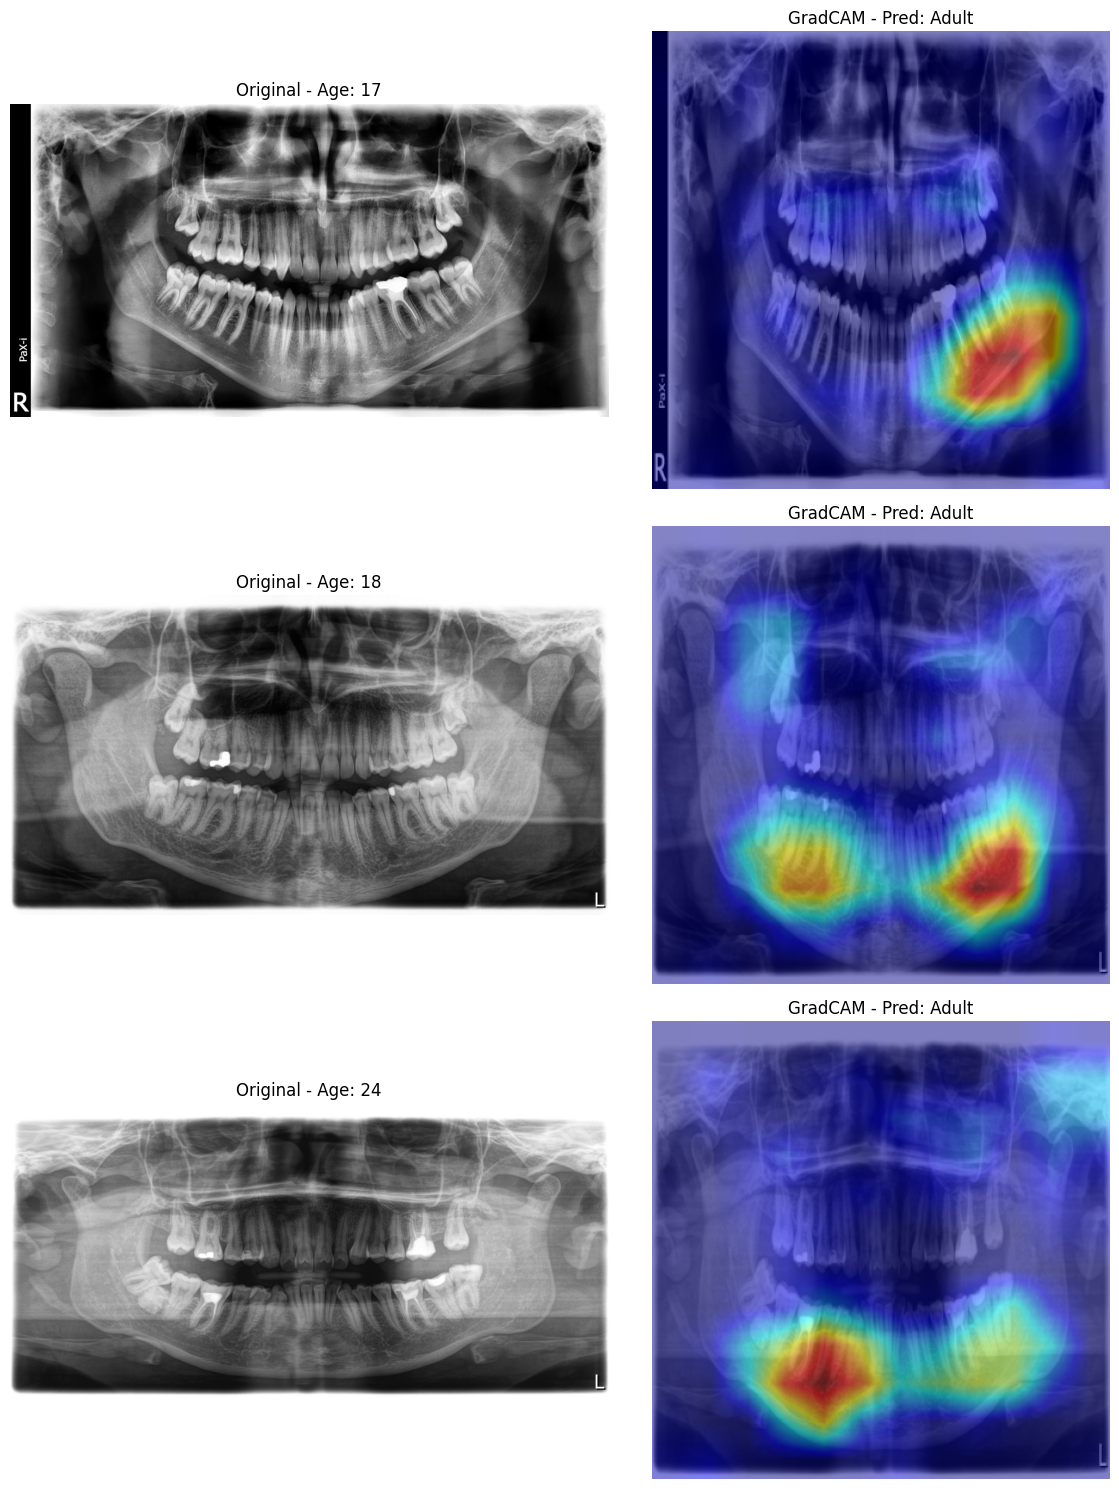

'Visualization completed'

In [20]:
visualize_model_interpretability(model, val_df, task_type='binary', backbone='efficientnet')

In [10]:
model, config, train_df, val_df = load_model_with_metadata(
    model_name="binary_vit_aug"
)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 252MB/s]


Model binary_vit_aug loaded successfully
Task type: binary, Backbone: vit
Sex filter: None, Augmentation: True
Created on: 2025-07-12 07:28:40


In [ ]:
visualize_model_interpretability(model, val_df, task_type='binary', backbone='vit')


Loading model: multiclass_efficientnet_aug
Model multiclass_efficientnet_aug loaded successfully
Task type: multiclass, Backbone: efficientnet
Sex filter: None, Augmentation: True
Created on: 2025-07-12 10:31:58
Using saved validation set with 353 samples
Evaluating multiclass_efficientnet_aug (multiclass, efficientnet)

Multiclass Classification Results:
Accuracy: 0.2946
MAE (years): 1.601
RMSE (years): 2.356
Generating required plots for multiclass_efficientnet_aug


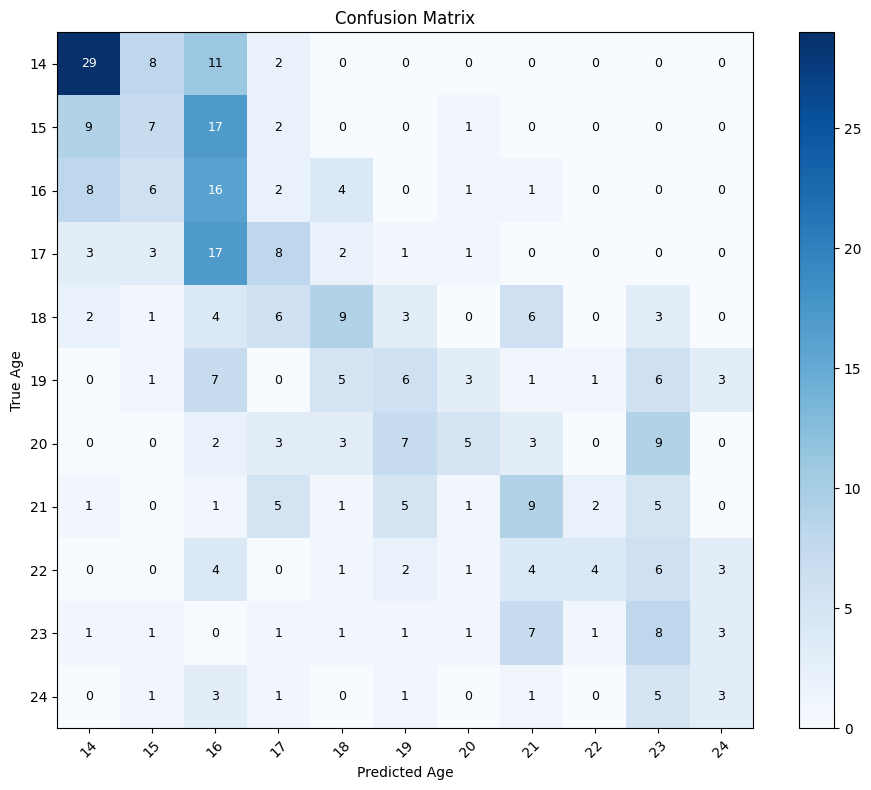

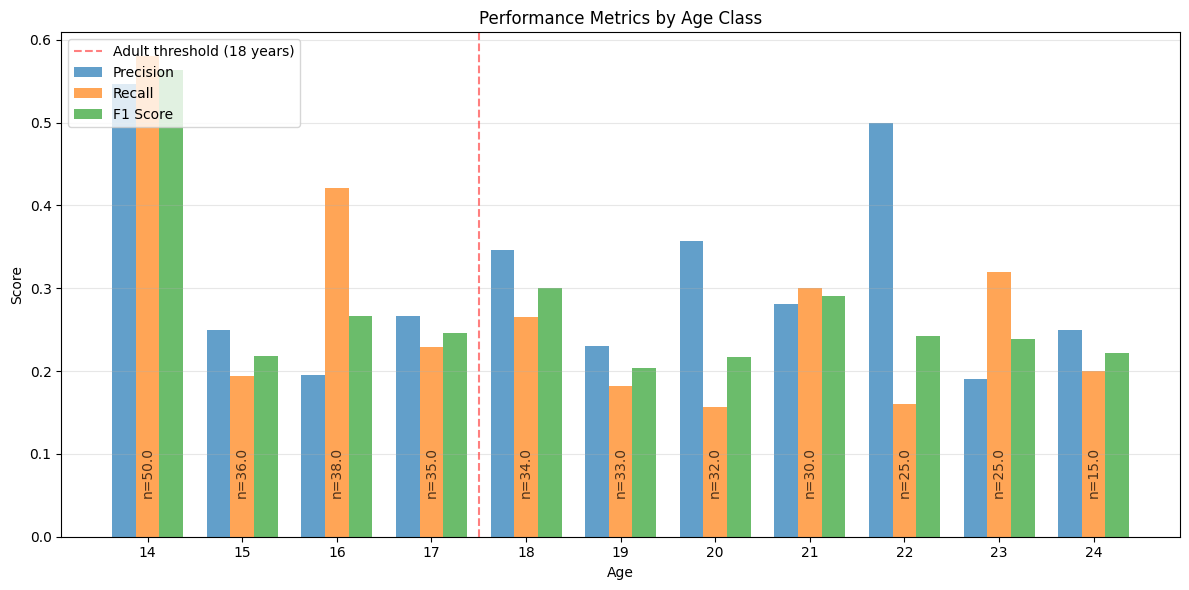


Loading model: multiclass_vit_aug
Model multiclass_vit_aug loaded successfully
Task type: multiclass, Backbone: vit
Sex filter: None, Augmentation: True
Created on: 2025-07-12 11:01:20
Using saved validation set with 353 samples
Evaluating multiclass_vit_aug (multiclass, vit)

Multiclass Classification Results:
Accuracy: 0.3059
MAE (years): 1.890
RMSE (years): 2.761
Generating required plots for multiclass_vit_aug


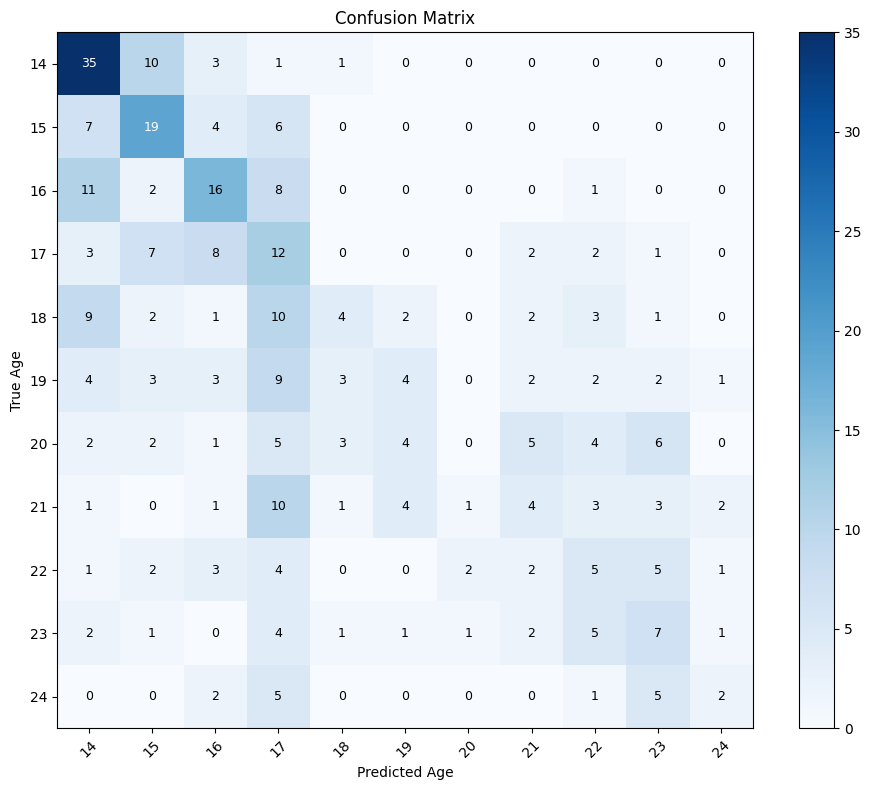

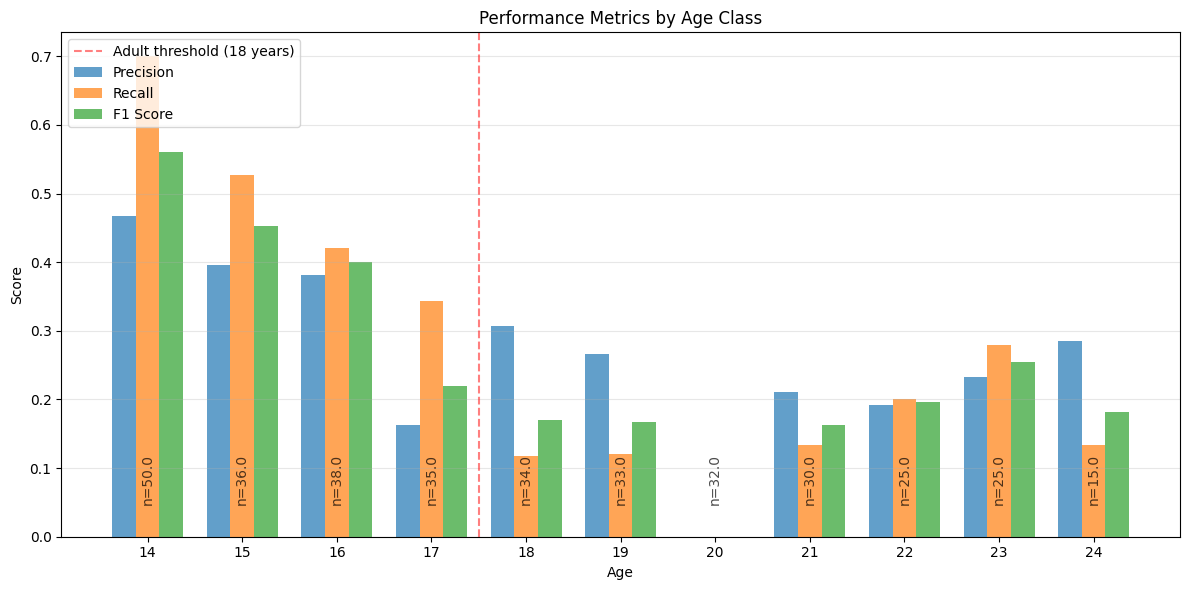


Loading model: regression_efficientnet_aug
Model regression_efficientnet_aug loaded successfully
Task type: regression, Backbone: efficientnet
Sex filter: None, Augmentation: True
Created on: 2025-07-12 09:14:47
Using saved validation set with 353 samples
Evaluating regression_efficientnet_aug (regression, efficientnet)

Regression Results:
MAE (years): 1.354 (95% CI: 1.240-1.477)
RMSE (years): 1.788
R²: 0.657
Binary classification accuracy: 0.8527 (95% CI: 0.8159-0.8868)
Sensitivity: 0.8351
Specificity: 0.8742

Age-specific MAE:
Age 14: 1.207 years, Within ±1 year: 56.0% (50 samples)
Age 15: 0.861 years, Within ±1 year: 75.0% (36 samples)
Age 16: 0.958 years, Within ±1 year: 55.3% (38 samples)
Age 17: 1.230 years, Within ±1 year: 45.7% (35 samples)
Age 18: 1.426 years, Within ±1 year: 44.1% (34 samples)
Age 19: 1.444 years, Within ±1 year: 42.4% (33 samples)
Age 20: 1.205 years, Within ±1 year: 53.1% (32 samples)
Age 21: 1.369 years, Within ±1 year: 46.7% (30 samples)
Age 22: 1.669 y

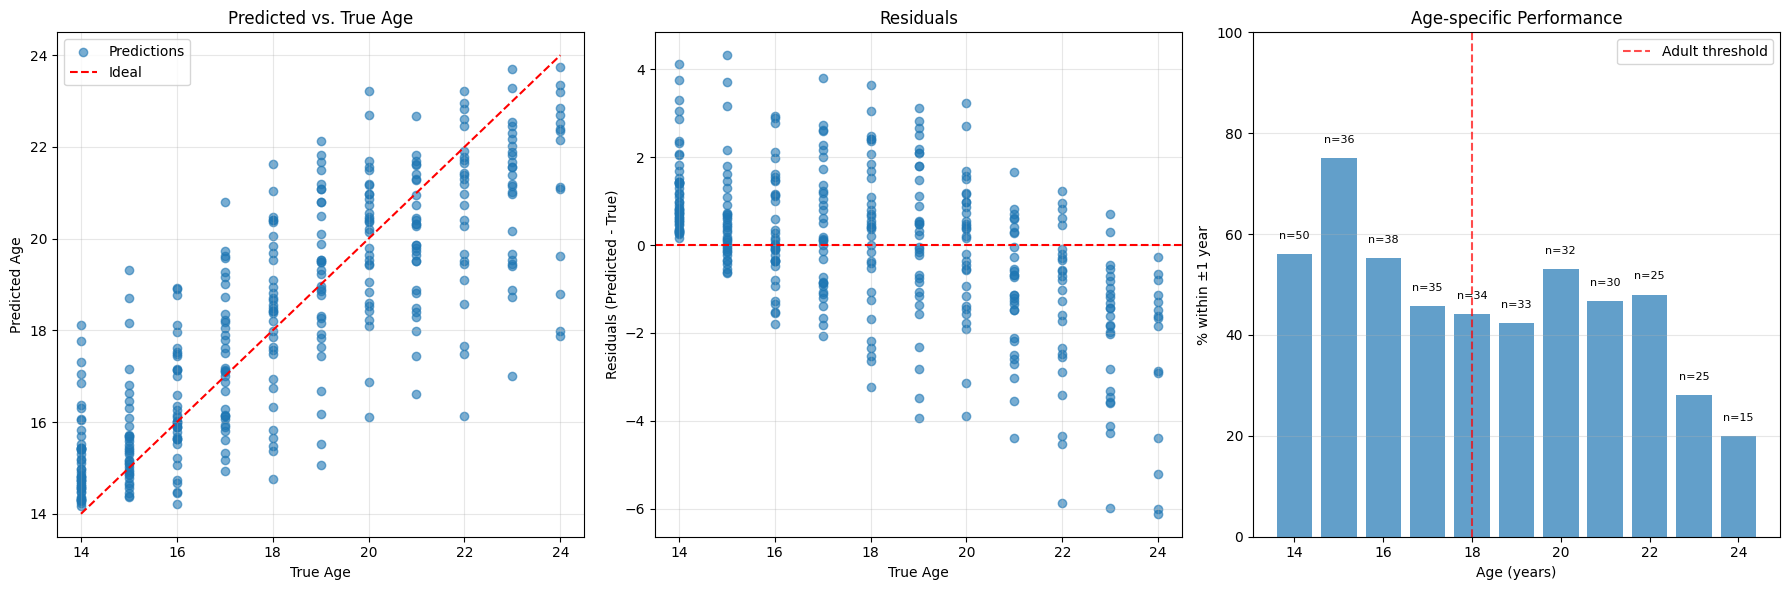

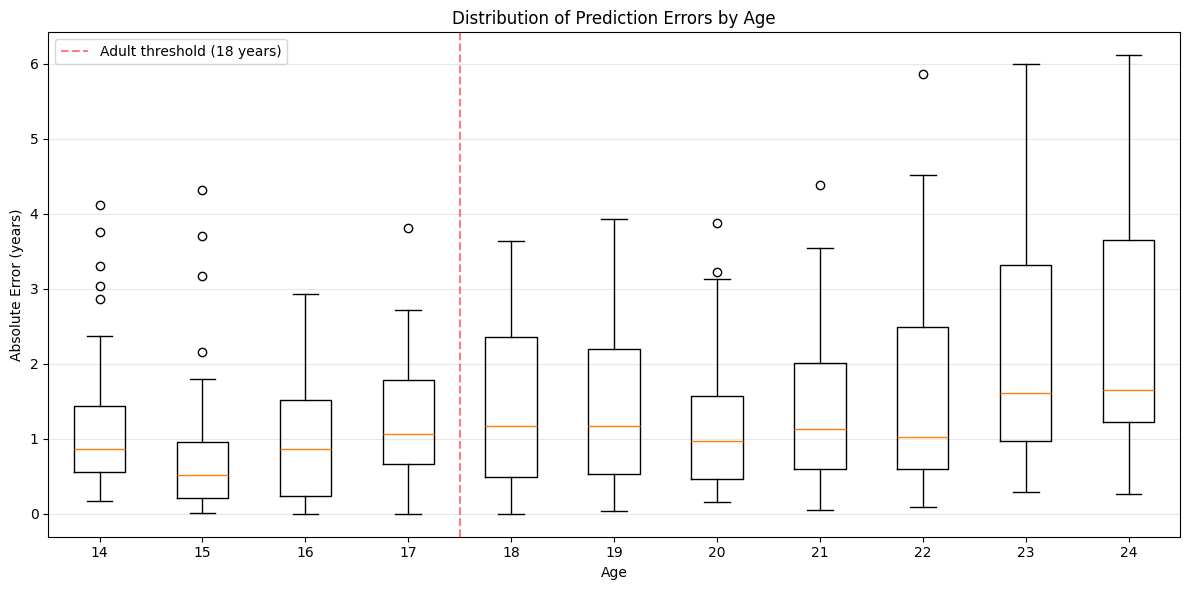


Loading model: regression_vit_aug
Model regression_vit_aug loaded successfully
Task type: regression, Backbone: vit
Sex filter: None, Augmentation: True
Created on: 2025-07-12 09:54:33
Using saved validation set with 353 samples
Evaluating regression_vit_aug (regression, vit)

Regression Results:
MAE (years): 1.455 (95% CI: 1.313-1.600)
RMSE (years): 1.991
R²: 0.574
Binary classification accuracy: 0.8300 (95% CI: 0.7931-0.8697)
Sensitivity: 0.7732
Specificity: 0.8994

Age-specific MAE:
Age 14: 1.041 years, Within ±1 year: 62.0% (50 samples)
Age 15: 0.783 years, Within ±1 year: 72.2% (36 samples)
Age 16: 0.922 years, Within ±1 year: 60.5% (38 samples)
Age 17: 1.242 years, Within ±1 year: 42.9% (35 samples)
Age 18: 1.465 years, Within ±1 year: 41.2% (34 samples)
Age 19: 1.463 years, Within ±1 year: 36.4% (33 samples)
Age 20: 1.228 years, Within ±1 year: 53.1% (32 samples)
Age 21: 1.641 years, Within ±1 year: 33.3% (30 samples)
Age 22: 1.881 years, Within ±1 year: 44.0% (25 samples)
Age 

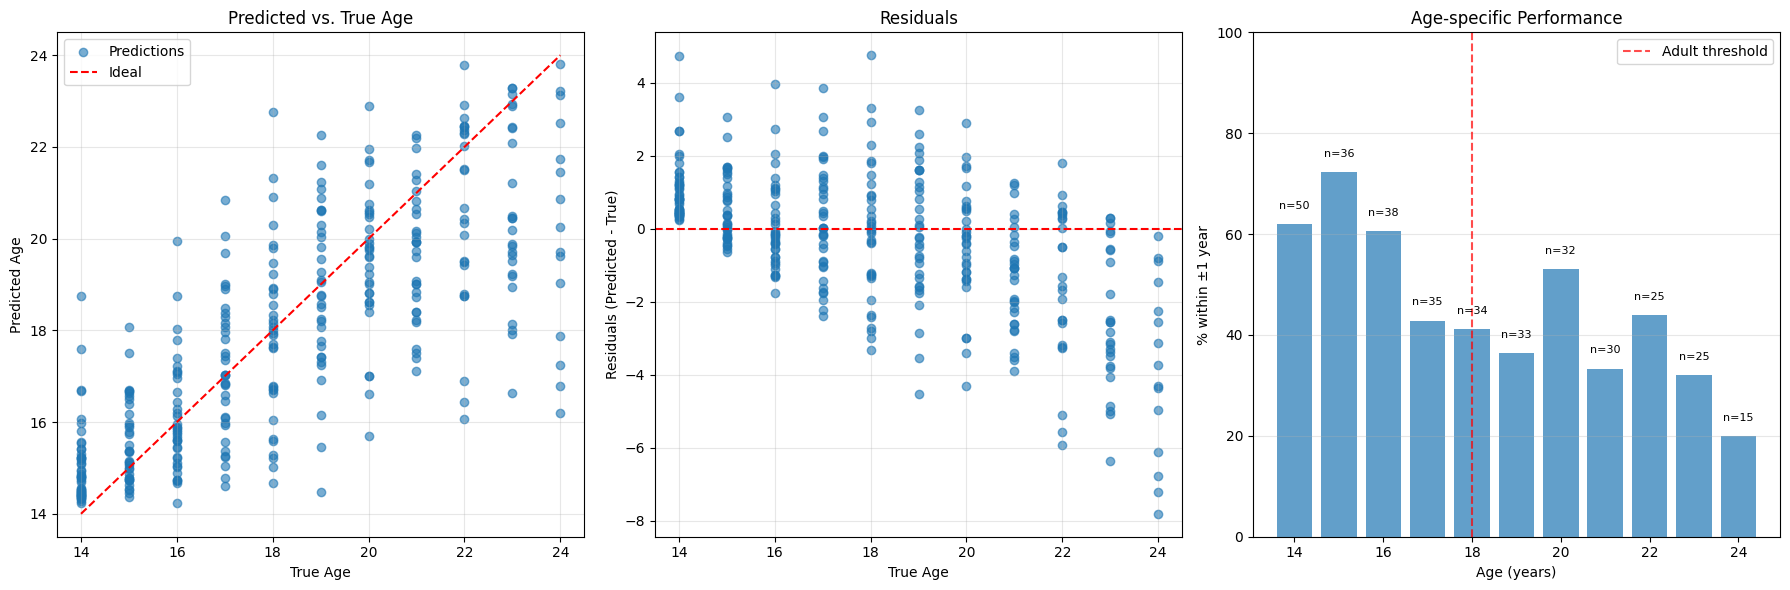

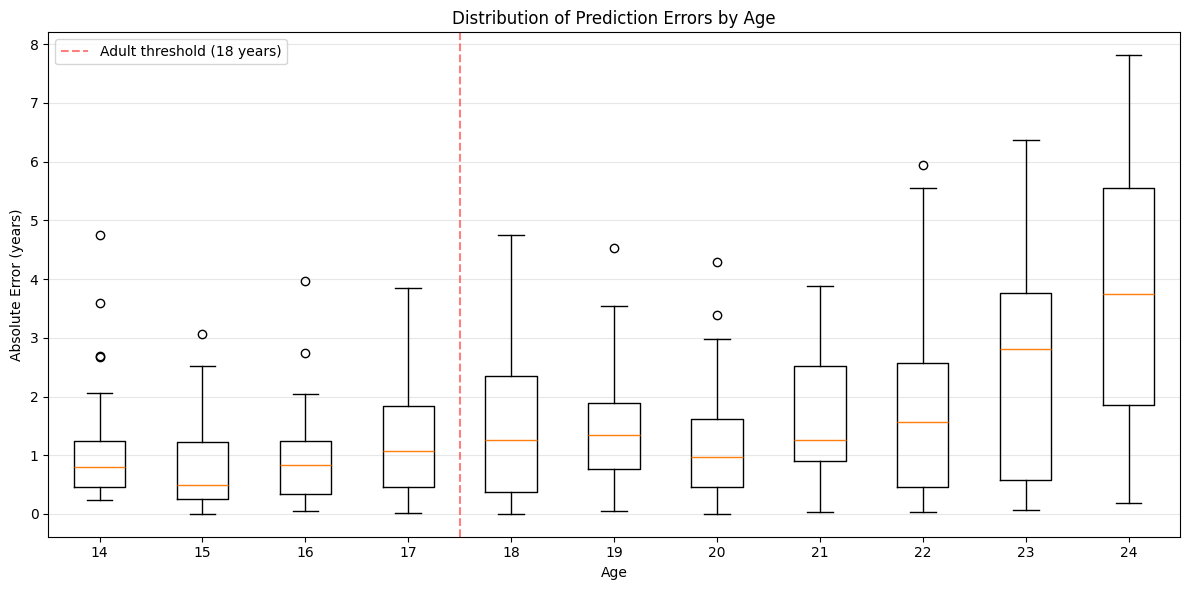


Done. All regression + multiclass plots generated correctly.


In [26]:
# ================================
# 3rd Revision Code
# Evaluate regression + multiclass using saved val_df.pkl
# Generates scatter plots, confusion matrices, etc.
# ================================

model_names = [
    "multiclass_efficientnet_aug",
    "multiclass_vit_aug",
    "regression_efficientnet_aug",
    "regression_vit_aug"
]

def infer_task_type(name):
    if "multiclass" in name:
        return "multiclass"
    if "regression" in name:
        return "regression"
    raise ValueError("Unknown task type in name")

def infer_backbone(name):
    return "vit" if "vit" in name.lower() else "efficientnet"

all_results = {}

for model_name in model_names:
    print("\n==============================")
    print(f"Loading model: {model_name}")
    print("==============================")

    # Load model, config, TRAIN_DF and VAL_DF saved during training
    model, config, train_df, val_df = load_model_with_metadata(model_name)

    task_type = infer_task_type(model_name)
    backbone  = infer_backbone(model_name)

    print(f"Using saved validation set with {len(val_df)} samples")

    # -----------------------------------
    # BUILD VAL DATASET FROM SAVED val_df.pkl
    # -----------------------------------
    _, val_transform = get_transforms(augment=False, backbone=backbone)
    val_dataset = DentalAgeDataset(val_df, val_transform, task_type=task_type)
    val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

    # -----------------------------------
    # EVALUATE MODEL (USING YOUR evaluate_model FUNCTION)
    # -----------------------------------
    print(f"Evaluating {model_name} ({task_type}, {backbone})")
    metrics = evaluate_model(model, val_loader, task_type=task_type)
    all_results[model_name] = metrics

    # -----------------------------------
    # GENERATE REQUIRED PLOTS FOR REVIEWER #2
    # -----------------------------------
    print(f"Generating required plots for {model_name}")

    if task_type == "multiclass":
        visualize_multiclass_results(metrics)

    if task_type == "regression":
        # This now works because metrics["predictions"] and metrics["targets"] exist
        visualize_regression_results(metrics)

print("\nDone. All regression + multiclass plots generated correctly.")
